Esta notebook contiene bloques de código útiles para realizar Q-learning en el entorno "CartPole-v1"

In [53]:
import gymnasium as gym
import numpy as np
import random

In [54]:
# Cambiar render_mode a rgb_array para entrenar/testear
env = gym.make('CartPole-v1', render_mode='rgb_array')

Observation Space

In [55]:
env.observation_space

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

Action Space

In [56]:
env.action_space

Discrete(2)

Discretización de los estados

In [20]:
# DISCRETIZACIÓN - Rangos de CartPole
cart_position = np.linspace(-4.8, 4.8, 10)
cart_velocity = np.linspace(-4, 4, 10)
pole_angle = np.linspace(-0.418, 0.418, 10)
pole_angular_velocity = np.linspace(-4, 4, 10)

print("Discretización uniforme:")
print(f"  Cart position bins: {len(cart_position)} bins en rango [-4.8, 4.8]")
print(f"  Cart velocity bins: {len(cart_velocity)} bins en rango [-4, 4]")
print(f"  Pole angle bins: {len(pole_angle)} bins en rango [-0.418, 0.418]")
print(f"  Pole angular velocity bins: {len(pole_angular_velocity)} bins en rango [-4, 4]")
print(f"\nEspacio de estados total: {(len(cart_position)+1) * (len(cart_velocity)+1) * (len(pole_angle)+1) * (len(pole_angular_velocity)+1):,} estados")

Discretización uniforme:
  Cart position bins: 10 bins en rango [-4.8, 4.8]
  Cart velocity bins: 10 bins en rango [-4, 4]
  Pole angle bins: 10 bins en rango [-0.418, 0.418]
  Pole angular velocity bins: 10 bins en rango [-4, 4]

Espacio de estados total: 14,641 estados


Obtener el estado a partir de la observación

In [58]:
def get_state(obs):
    cart_pos = obs[0]
    cart_vel = obs[1]
    pole_ang = obs[2]
    pole_ang_vel = obs[3]
    cart_pos_idx = np.digitize(cart_pos, cart_position)
    cart_vel_idx = np.digitize(cart_vel, cart_velocity)
    pole_angle_idx = np.digitize(pole_ang, pole_angle)
    pole_ang_vel_idx = np.digitize(pole_ang_vel, pole_angular_velocity)
    return cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx

In [59]:
obs = env.observation_space.sample()
print(obs)
state = get_state(obs)
state

[-2.8827462   0.1813486   0.22906707 -0.802198  ]


(np.int64(2), np.int64(5), np.int64(7), np.int64(4))

Inicilización de la tabla Q

In [60]:
Q = np.zeros((len(cart_position), len(cart_velocity), len(pole_angle), len(pole_angular_velocity), env.action_space.n))
Q

array([[[[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         ...,

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
    

Obtención de la acción a partir de la tabla Q

In [61]:
def optimal_policy(state, Q):
    action = np.argmax(Q[state])
    return action

Epsilon-Greedy Policy

In [62]:
def epsilon_greedy_policy(state, Q, epsilon=0.1):
    explore = np.random.binomial(1, epsilon)
    if explore:
        action = env.action_space.sample()
    else:
        action = optimal_policy(state, Q)
        
    return action

Ejemplo de episodio 

In [63]:
obs,_ = env.reset()
print(obs)
done = False
total_reward = 0
state = get_state(obs)
steps = 0
while not done:
    steps += 1
    
    # Acción del modelo
    action = epsilon_greedy_policy(state, Q, 0.5)
    print('action', action)

    obs, reward, done, _, _ = env.step(action)
    next_state = get_state(obs)
    
   # Q[state][action_idx] = ... # Completar
   
   # Actualizar estado
    state = next_state
   
    total_reward += reward

    env.render()

env.close() # Para cerrar la ventana, hay que crear el ambiente de nuevo si queremos correrlo otra vez   
print('total_reward', total_reward)
print('steps', steps)

[ 0.02766699 -0.02187406 -0.00096074 -0.03741703]
action 0
action 1
action 0
action 0
action 0
action 0
action 0
action 1
action 0
action 0
action 0
action 0
total_reward 12.0
steps 12
action 1
action 0
action 0
action 0
action 0
action 0
action 1
action 0
action 0
action 0
action 0
total_reward 12.0
steps 12


## FASE 2: DISCRETIZACION DEL ESPACIO DE ESTADOS

CartPole-v1 tiene un espacio de observacion **continuo** de 4 dimensiones. Para usar Q-Learning tabular, necesitamos **discretizarlo**.

### Rangos reales de CartPole-v1:
- **Ubicación del vehiculo:** [-4.8, 4.8]
- **Velocidad del vehículo:** [-Inf, Inf] → practicamente [-4, 4]
- **Angulo del poste:** [-0.418, 0.418] radianes → ±24 grados
- **Velocidad angular:** [-Inf, Inf] → practicamente [-4, 4]

### Estrategia de Discretización

Implementaremos **tres esquemas de discretización** con diferente granularidad:

1. **GRUESA (3-4 bins):** Espacio de estados compacto (~400 estados) para baseline rápido
2. **MEDIA (7-8 bins):** Balance óptimo entre precisión y velocidad (~5,000 estados)
3. **FINA (11-12 bins):** Máxima precisión para control fino (~24,000 estados)

**Criterio clave:** La cantidad de episodios de entrenamiento debe ser proporcional al tamaño del espacio de estados para garantizar exploración suficiente.

### ESQUEMA 1: Discretizacion GRUESA

Dividimos cada dimension en **3-4 bins**. Espacio de estados muy compacto para convergencia rapida.

In [64]:
import matplotlib.pyplot as plt

# ESQUEMA 1: Discretizacion GRUESA (3-4 bins por dimension)
bins_coarse = {
    'cart_position': np.linspace(-4.8, 4.8, 3),
    'cart_velocity': np.linspace(-4, 4, 4),
    'pole_angle': np.linspace(-0.418, 0.418, 4),
    'pole_angular_velocity': np.linspace(-4, 4, 3)
}

def get_state_coarse(obs):
    """Convierte observacion continua en estado discreto (gruesa)"""
    cart_pos_idx = np.digitize(obs[0], bins_coarse['cart_position'])
    cart_vel_idx = np.digitize(obs[1], bins_coarse['cart_velocity'])
    pole_angle_idx = np.digitize(obs[2], bins_coarse['pole_angle'])
    pole_ang_vel_idx = np.digitize(obs[3], bins_coarse['pole_angular_velocity'])
    return (cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx)

# Tamano del espacio de estados
state_space_coarse = (len(bins_coarse['cart_position']) + 1,
                      len(bins_coarse['cart_velocity']) + 1,
                      len(bins_coarse['pole_angle']) + 1,
                      len(bins_coarse['pole_angular_velocity']) + 1)

print(f"Espacio de estados (GRUESA): {state_space_coarse}")
print(f"Tamano total: {np.prod(state_space_coarse):,} estados posibles")
print(f"Episodios recomendados: {np.prod(state_space_coarse) * 5:,} - {np.prod(state_space_coarse) * 10:,}")

Espacio de estados (GRUESA): (4, 5, 5, 4)
Tamano total: 400 estados posibles
Episodios recomendados: 2,000 - 4,000


### ESQUEMA 2: Discretizacion MEDIA

Dividimos cada dimension en **7-8 bins**. Balance optimo entre precision y velocidad de entrenamiento.

In [65]:
# ESQUEMA 2: Discretizacion MEDIA (7-8 bins por dimension)

bins_medium = {
    'cart_position': np.linspace(-4.8, 4.8, 7),
    'cart_velocity': np.linspace(-4, 4, 7),
    'pole_angle': np.linspace(-0.418, 0.418, 8),
    'pole_angular_velocity': np.linspace(-4, 4, 8)
}

def get_state_medium(obs):
    """Convierte observacion continua en estado discreto (media)"""
    cart_pos_idx = np.digitize(obs[0], bins_medium['cart_position'])
    cart_vel_idx = np.digitize(obs[1], bins_medium['cart_velocity'])
    pole_angle_idx = np.digitize(obs[2], bins_medium['pole_angle'])
    pole_ang_vel_idx = np.digitize(obs[3], bins_medium['pole_angular_velocity'])
    return (cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx)

# Tamano del espacio de estados
state_space_medium = (len(bins_medium['cart_position']) + 1,
                      len(bins_medium['cart_velocity']) + 1,
                      len(bins_medium['pole_angle']) + 1,
                      len(bins_medium['pole_angular_velocity']) + 1)

print(f"Espacio de estados (MEDIA): {state_space_medium}")
print(f"Tamano total: {np.prod(state_space_medium):,} estados posibles")
print(f"Episodios recomendados: {np.prod(state_space_medium) * 1.5:.0f} - {np.prod(state_space_medium) * 2.5:.0f}")

Espacio de estados (MEDIA): (8, 8, 9, 9)
Tamano total: 5,184 estados posibles
Episodios recomendados: 7776 - 12960


### ESQUEMA 3: Discretizacion FINA

Dividimos cada dimension en **11-12 bins**. Maxima precision para control fino del sistema.

In [66]:
# ESQUEMA 3: Discretizacion FINA (11-12 bins por dimension)

bins_fine = {
    'cart_position': np.linspace(-4.8, 4.8, 11),
    'cart_velocity': np.linspace(-4, 4, 11),
    'pole_angle': np.linspace(-0.418, 0.418, 12),
    'pole_angular_velocity': np.linspace(-4, 4, 12)
}

def get_state_fine(obs):
    """Convierte observacion continua en estado discreto (fina)"""
    cart_pos_idx = np.digitize(obs[0], bins_fine['cart_position'])
    cart_vel_idx = np.digitize(obs[1], bins_fine['cart_velocity'])
    pole_angle_idx = np.digitize(obs[2], bins_fine['pole_angle'])
    pole_ang_vel_idx = np.digitize(obs[3], bins_fine['pole_angular_velocity'])
    return (cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx)

# Tamano del espacio de estados
state_space_fine = (len(bins_fine['cart_position']) + 1,
                    len(bins_fine['cart_velocity']) + 1,
                    len(bins_fine['pole_angle']) + 1,
                    len(bins_fine['pole_angular_velocity']) + 1)

print(f"Espacio de estados (FINA): {state_space_fine}")
print(f"Tamano total: {np.prod(state_space_fine):,} estados posibles")
print(f"Episodios recomendados: {np.prod(state_space_fine) * 1.2:.0f} - {np.prod(state_space_fine) * 1.7:.0f}")

Espacio de estados (FINA): (12, 12, 13, 13)
Tamano total: 24,336 estados posibles
Episodios recomendados: 29203 - 41371


### VERIFICACION 1: Visualizar las tres discretizaciones

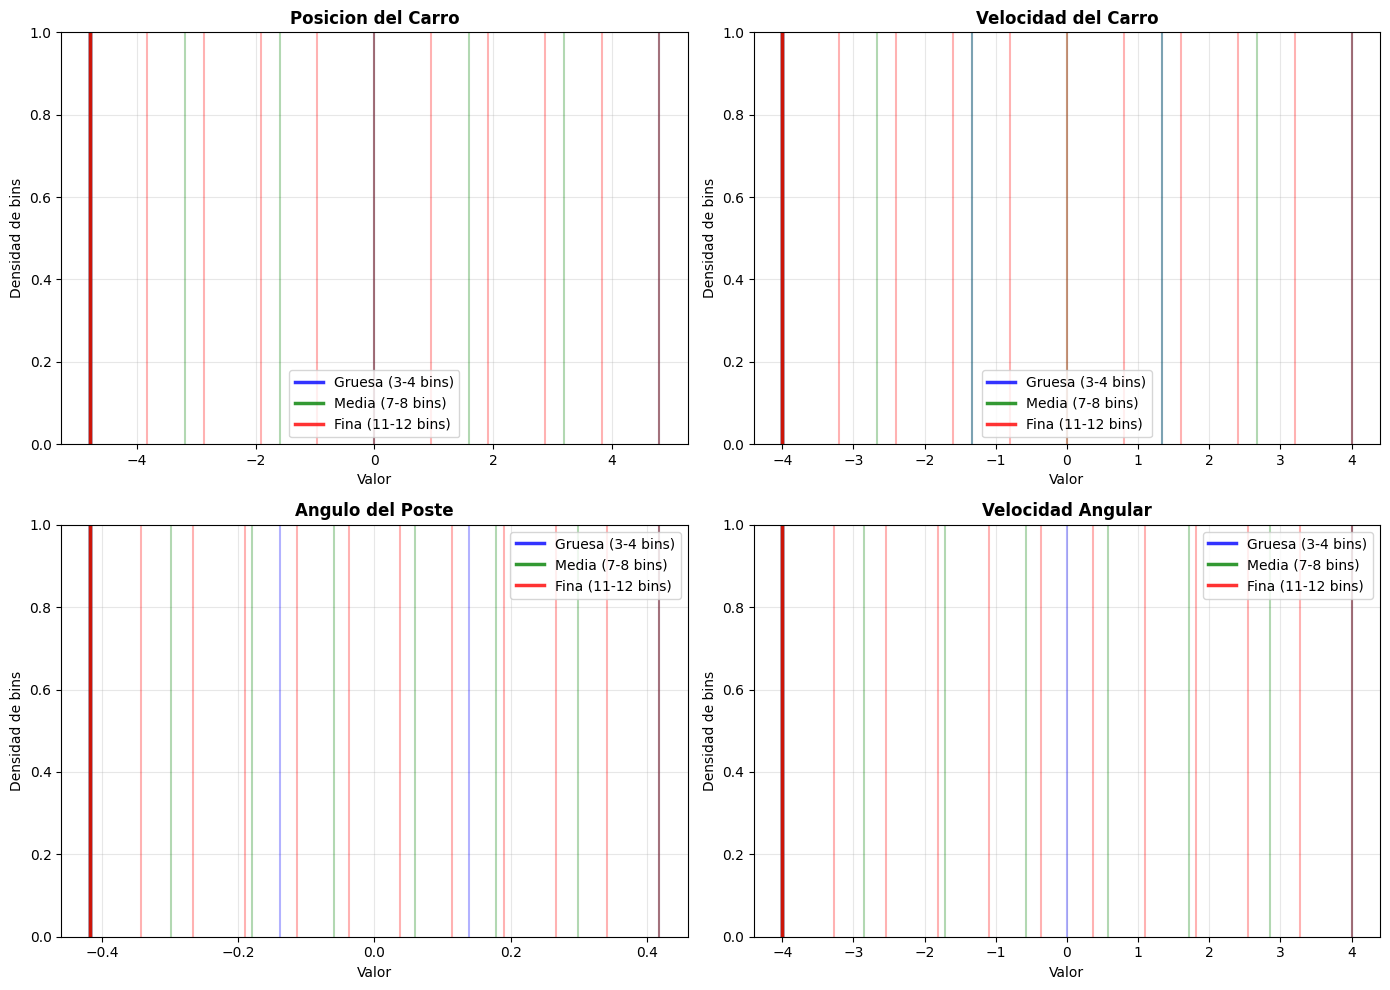


Grafico: Distribucion de bins para cada esquema
- AZUL: Gruesa (espaciado muy amplio)
- VERDE: Media (espaciado moderado)
- ROJO: Fina (espaciado fino)


In [67]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
variables = ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']
titles = ['Posicion del Carro', 'Velocidad del Carro', 'Angulo del Poste', 'Velocidad Angular']

for idx, (var, title) in enumerate(zip(variables, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Bins como lineas verticales
    for bin_val in bins_coarse[var]:
        ax.axvline(bin_val, color='blue', alpha=0.3, linewidth=1.5)
    for bin_val in bins_medium[var]:
        ax.axvline(bin_val, color='green', alpha=0.3, linewidth=1.5)
    for bin_val in bins_fine[var]:
        ax.axvline(bin_val, color='red', alpha=0.3, linewidth=1.5)
    
    # Leyenda
    ax.axvline(bins_coarse[var][0], color='blue', alpha=0.8, linewidth=2.5, label='Gruesa (3-4 bins)')
    ax.axvline(bins_medium[var][0], color='green', alpha=0.8, linewidth=2.5, label='Media (7-8 bins)')
    ax.axvline(bins_fine[var][0], color='red', alpha=0.8, linewidth=2.5, label='Fina (11-12 bins)')
    
    ax.set_title(f'{title}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Densidad de bins')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nGrafico: Distribucion de bins para cada esquema")
print("- AZUL: Gruesa (espaciado muy amplio)")
print("- VERDE: Media (espaciado moderado)")
print("- ROJO: Fina (espaciado fino)")

### VERIFICACION 2: Probar las funciones de discretizacion

In [68]:
# Test con observacion especifica
obs_test = np.array([0.5, -0.3, 0.05, 1.2])
print("Observacion de prueba:", obs_test)
print("  Estado GRUESA:", get_state_coarse(obs_test))
print("  Estado MEDIA: ", get_state_medium(obs_test))
print("  Estado FINA:  ", get_state_fine(obs_test))

# Test con muestreo aleatorio
print("\n" + "="*70)
print("Muestreando 1000 observaciones aleatorias del entorno...")
n_samples = 1000
states_coarse = []
states_medium = []
states_fine = []

for _ in range(n_samples):
    obs = env.observation_space.sample()
    states_coarse.append(get_state_coarse(obs))
    states_medium.append(get_state_medium(obs))
    states_fine.append(get_state_fine(obs))

unique_coarse = len(set(states_coarse))
unique_medium = len(set(states_medium))
unique_fine = len(set(states_fine))

print(f"\nEstados unicos visitados en el muestreo:")
print(f"  GRUESA: {unique_coarse:,} / {np.prod(state_space_coarse):,} posibles ({unique_coarse/np.prod(state_space_coarse)*100:.1f}%)")
print(f"  MEDIA:  {unique_medium:,} / {np.prod(state_space_medium):,} posibles ({unique_medium/np.prod(state_space_medium)*100:.1f}%)")
print(f"  FINA:   {unique_fine:,} / {np.prod(state_space_fine):,} posibles ({unique_fine/np.prod(state_space_fine)*100:.1f}%)")
print("\nA mayor granularidad, mayor cantidad de estados posibles.")

Observacion de prueba: [ 0.5  -0.3   0.05  1.2 ]
  Estado GRUESA: (np.int64(2), np.int64(2), np.int64(2), np.int64(2))
  Estado MEDIA:  (np.int64(4), np.int64(3), np.int64(4), np.int64(5))
  Estado FINA:   (np.int64(6), np.int64(5), np.int64(7), np.int64(8))

Muestreando 1000 observaciones aleatorias del entorno...

Estados unicos visitados en el muestreo:
  GRUESA: 38 / 400 posibles (9.5%)
  MEDIA:  424 / 5,184 posibles (8.2%)
  FINA:   816 / 24,336 posibles (3.4%)

A mayor granularidad, mayor cantidad de estados posibles.


### VERIFICACION 3: Tabla comparativa

In [69]:
import pandas as pd

comparison_data = {
    'Caracteristica': [
        'Total de estados',
        'Bins: posicion carro',
        'Bins: velocidad carro',
        'Bins: angulo poste',
        'Bins: velocidad angular',
        'Estrategia',
        'Episodios recomendados',
        'Ventaja principal'
    ],
    'Gruesa': [
        f"{np.prod(state_space_coarse):,}",
        len(bins_coarse['cart_position']),
        len(bins_coarse['cart_velocity']),
        len(bins_coarse['pole_angle']),
        len(bins_coarse['pole_angular_velocity']),
        'Muy compacta',
        '2,000-2,500',
        'Convergencia rapida'
    ],
    'Media': [
        f"{np.prod(state_space_medium):,}",
        len(bins_medium['cart_position']),
        len(bins_medium['cart_velocity']),
        len(bins_medium['pole_angle']),
        len(bins_medium['pole_angular_velocity']),
        'Balanceada',
        '8,000-12,000',
        'Balance precision/velocidad'
    ],
    'Fina': [
        f"{np.prod(state_space_fine):,}",
        len(bins_fine['cart_position']),
        len(bins_fine['cart_velocity']),
        len(bins_fine['pole_angle']),
        len(bins_fine['pole_angular_velocity']),
        'Alta precision',
        '30,000-40,000',
        'Control fino'
    ]
}

df = pd.DataFrame(comparison_data)
print("\n" + "="*90)
print("COMPARACION DE ESQUEMAS DE DISCRETIZACION")
print("="*90)
print(df.to_string(index=False))
print("="*90)
print("\nLos tres esquemas seran probados en la FASE 3 para ver cual funciona mejor.")


COMPARACION DE ESQUEMAS DE DISCRETIZACION
         Caracteristica              Gruesa                       Media           Fina
       Total de estados                 400                       5,184         24,336
   Bins: posicion carro                   3                           7             11
  Bins: velocidad carro                   4                           7             11
     Bins: angulo poste                   4                           8             12
Bins: velocidad angular                   3                           8             12
             Estrategia        Muy compacta                  Balanceada Alta precision
 Episodios recomendados         2,000-2,500                8,000-12,000  30,000-40,000
      Ventaja principal Convergencia rapida Balance precision/velocidad   Control fino

Los tres esquemas seran probados en la FASE 3 para ver cual funciona mejor.


### FASE 3: Comparacion de discretizaciones con Q-Learning

En esta fase entrenaremos un agente de Q-Learning con cada uno de los tres esquemas de discretizacion para comparar su rendimiento.

**Configuracion del test:**
- Discretizaciones: GRUESA (400 estados), MEDIA (5,184 estados), FINA (24,336 estados)
- Episodios de entrenamiento: 1,000 episodios para cada esquema (test rapido)
- Hiperparametros fijos: alpha=0.1, gamma=0.99, epsilon_decay=0.995
- Epsilon: Decae desde 1.0 hasta 0.01
- Evaluacion: 100 episodios sin exploracion (epsilon=0)

**Objetivo:**
- Comparar velocidad de convergencia
- Analizar rendimiento final
- Determinar trade-off entre precision y tiempo de entrenamiento
- Identificar cual discretizacion es mas adecuada para CartPole

#### Test 1: Entrenamiento con Discretizacion GRUESA (400 estados)

In [ ]:
def q_learning_train(episodes, alpha, gamma, epsilon_decay, get_state_fn, state_space, verbose=True):
    q_table = np.zeros((*state_space, env.action_space.n))
    epsilon = 1.0
    epsilon_min = 0.01
    
    rewards_per_episode = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = get_state_fn(state)
        
        episode_reward = 0
        done = False
        
        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = get_state_fn(next_state)
            
            old_value = q_table[state + (action,)]
            next_max = np.max(q_table[next_state])
            new_value = old_value + alpha * (reward + gamma * next_max - old_value)
            q_table[state + (action,)] = new_value
            
            state = next_state
            episode_reward += reward
        
        rewards_per_episode.append(episode_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        if verbose and (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            print(f"Episodio {episode + 1}/{episodes} - Recompensa promedio (ultimos 100): {avg_reward:.2f} - Epsilon: {epsilon:.4f}")
    
    return q_table, rewards_per_episode

def evaluate_policy(q_table, get_state_fn, episodes=100, verbose=True):
    total_rewards = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = get_state_fn(state)
        
        episode_reward = 0
        done = False
        
        while not done:
            action = np.argmax(q_table[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = get_state_fn(next_state)
            episode_reward += reward
        
        total_rewards.append(episode_reward)
    
    if verbose:
        print(f"\nEvaluacion completa: {episodes} episodios")
        print(f"Recompensa promedio: {np.mean(total_rewards):.2f}")
        print(f"Desviacion estandar: {np.std(total_rewards):.2f}")
        print(f"Recompensa minima: {np.min(total_rewards):.2f}")
        print(f"Recompensa maxima: {np.max(total_rewards):.2f}")
    
    return total_rewards

print("Entrenando con discretizacion GRUESA (400 estados)...")
print("="*60)
q_table_coarse, rewards_coarse = q_learning_train(
    episodes=1000,
    alpha=0.1,
    gamma=0.99,
    epsilon_decay=0.995,
    get_state_fn=get_state_coarse,
    state_space=state_space_coarse
)

print("\nEvaluando politica aprendida...")
eval_rewards_coarse = evaluate_policy(q_table_coarse, get_state_coarse)

Entrenando con discretizacion GRUESA (400 estados)...
Episodio 100/1000 - Recompensa promedio (ultimos 100): 26.03 - Epsilon: 0.6058
Episodio 100/1000 - Recompensa promedio (ultimos 100): 26.03 - Epsilon: 0.6058
Episodio 200/1000 - Recompensa promedio (ultimos 100): 46.57 - Epsilon: 0.3670Episodio 200/1000 - Recompensa promedio (ultimos 100): 46.57 - Epsilon: 0.3670
Episodio 300/1000 - Recompensa promedio (ultimos 100): 68.45 - Epsilon: 0.2223

Episodio 300/1000 - Recompensa promedio (ultimos 100): 68.45 - Epsilon: 0.2223
Episodio 400/1000 - Recompensa promedio (ultimos 100): 69.99 - Epsilon: 0.1347
Episodio 400/1000 - Recompensa promedio (ultimos 100): 69.99 - Epsilon: 0.1347
Episodio 500/1000 - Recompensa promedio (ultimos 100): 91.24 - Epsilon: 0.0816
Episodio 500/1000 - Recompensa promedio (ultimos 100): 91.24 - Epsilon: 0.0816
Episodio 600/1000 - Recompensa promedio (ultimos 100): 109.92 - Epsilon: 0.0494
Episodio 600/1000 - Recompensa promedio (ultimos 100): 109.92 - Epsilon: 0.0

#### Test 2: Entrenamiento con Discretizacion MEDIA (5,184 estados)

In [71]:
print("Entrenando con discretizacion MEDIA (5,184 estados)...")
print("="*60)
q_table_medium, rewards_medium = q_learning_train(
    episodes=1000,
    alpha=0.1,
    gamma=0.99,
    epsilon_decay=0.995,
    get_state_fn=get_state_medium,
    state_space=state_space_medium
)

print("\nEvaluando politica aprendida...")
eval_rewards_medium = evaluate_policy(q_table_medium, get_state_medium)

Entrenando con discretizacion MEDIA (5,184 estados)...
Episodio 100/1000 - Recompensa promedio (ultimos 100): 25.13 - Epsilon: 0.6058
Episodio 200/1000 - Recompensa promedio (ultimos 100): 29.37 - Epsilon: 0.3670
Episodio 300/1000 - Recompensa promedio (ultimos 100): 39.74 - Epsilon: 0.2223
Episodio 400/1000 - Recompensa promedio (ultimos 100): 51.72 - Epsilon: 0.1347
Episodio 300/1000 - Recompensa promedio (ultimos 100): 39.74 - Epsilon: 0.2223
Episodio 400/1000 - Recompensa promedio (ultimos 100): 51.72 - Epsilon: 0.1347
Episodio 500/1000 - Recompensa promedio (ultimos 100): 67.50 - Epsilon: 0.0816
Episodio 600/1000 - Recompensa promedio (ultimos 100): 48.27 - Epsilon: 0.0494
Episodio 500/1000 - Recompensa promedio (ultimos 100): 67.50 - Epsilon: 0.0816
Episodio 600/1000 - Recompensa promedio (ultimos 100): 48.27 - Epsilon: 0.0494
Episodio 700/1000 - Recompensa promedio (ultimos 100): 50.45 - Epsilon: 0.0299
Episodio 700/1000 - Recompensa promedio (ultimos 100): 50.45 - Epsilon: 0.02

#### Test 3: Entrenamiento con Discretizacion FINA (24,336 estados)

Nota: Esta discretizacion tiene un espacio de estados mucho mas grande, por lo que podria necesitar mas episodios para convergencia optima. Sin embargo, usaremos 1,000 episodios para mantener la comparacion equitativa.

In [72]:
print("Entrenando con discretizacion FINA (24,336 estados)...")
print("="*60)
q_table_fine, rewards_fine = q_learning_train(
    episodes=1000,
    alpha=0.1,
    gamma=0.99,
    epsilon_decay=0.995,
    get_state_fn=get_state_fine,
    state_space=state_space_fine
)

print("\nEvaluando politica aprendida...")
eval_rewards_fine = evaluate_policy(q_table_fine, get_state_fine)

Entrenando con discretizacion FINA (24,336 estados)...
Episodio 100/1000 - Recompensa promedio (ultimos 100): 26.47 - Epsilon: 0.6058
Episodio 200/1000 - Recompensa promedio (ultimos 100): 27.49 - Epsilon: 0.3670
Episodio 100/1000 - Recompensa promedio (ultimos 100): 26.47 - Epsilon: 0.6058
Episodio 200/1000 - Recompensa promedio (ultimos 100): 27.49 - Epsilon: 0.3670
Episodio 300/1000 - Recompensa promedio (ultimos 100): 26.20 - Epsilon: 0.2223
Episodio 300/1000 - Recompensa promedio (ultimos 100): 26.20 - Epsilon: 0.2223
Episodio 400/1000 - Recompensa promedio (ultimos 100): 26.09 - Epsilon: 0.1347
Episodio 400/1000 - Recompensa promedio (ultimos 100): 26.09 - Epsilon: 0.1347
Episodio 500/1000 - Recompensa promedio (ultimos 100): 26.78 - Epsilon: 0.0816
Episodio 600/1000 - Recompensa promedio (ultimos 100): 26.29 - Epsilon: 0.0494
Episodio 500/1000 - Recompensa promedio (ultimos 100): 26.78 - Epsilon: 0.0816
Episodio 600/1000 - Recompensa promedio (ultimos 100): 26.29 - Epsilon: 0.04

#### Comparacion de resultados

In [73]:
import pandas as pd

results_comparison = {
    'Esquema': ['Gruesa', 'Media', 'Fina'],
    'Estados': [
        np.prod(state_space_coarse),
        np.prod(state_space_medium),
        np.prod(state_space_fine)
    ],
    'Reward promedio (eval)': [
        np.mean(eval_rewards_coarse),
        np.mean(eval_rewards_medium),
        np.mean(eval_rewards_fine)
    ],
    'Desv. std. (eval)': [
        np.std(eval_rewards_coarse),
        np.std(eval_rewards_medium),
        np.std(eval_rewards_fine)
    ],
    'Reward max (train)': [
        np.max(rewards_coarse),
        np.max(rewards_medium),
        np.max(rewards_fine)
    ],
    'Reward promedio ultimos 100': [
        np.mean(rewards_coarse[-100:]),
        np.mean(rewards_medium[-100:]),
        np.mean(rewards_fine[-100:])
    ]
}

df_results = pd.DataFrame(results_comparison)
print("\n" + "="*100)
print("COMPARACION DE LOS TRES ESQUEMAS DE DISCRETIZACION")
print("="*100)
print(df_results.to_string(index=False))
print("="*100)

print("\nAnalisis:")
best_idx = df_results['Reward promedio (eval)'].idxmax()
best_scheme = df_results.loc[best_idx, 'Esquema']
best_reward = df_results.loc[best_idx, 'Reward promedio (eval)']
print(f"Mejor esquema: {best_scheme} con reward promedio de {best_reward:.2f}")

print("\nObservaciones:")
print("- Discretizacion GRUESA: Pocos estados, convergencia rapida pero control menos preciso")
print("- Discretizacion MEDIA: Balance entre precision y tiempo de convergencia")
print("- Discretizacion FINA: Muchos estados, requiere mas exploracion pero control mas preciso")


COMPARACION DE LOS TRES ESQUEMAS DE DISCRETIZACION
Esquema  Estados  Reward promedio (eval)  Desv. std. (eval)  Reward max (train)  Reward promedio ultimos 100
 Gruesa      400                   78.75          67.587184               410.0                       163.82
  Media     5184                   19.69           3.568459               239.0                        19.52
   Fina    24336                   27.20           5.767148                82.0                        27.01

Analisis:
Mejor esquema: Gruesa con reward promedio de 78.75

Observaciones:
- Discretizacion GRUESA: Pocos estados, convergencia rapida pero control menos preciso
- Discretizacion MEDIA: Balance entre precision y tiempo de convergencia
- Discretizacion FINA: Muchos estados, requiere mas exploracion pero control mas preciso


C:\Users\juanp\AppData\Local\Temp\ipykernel_43424\1013354263.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(eval_data, labels=labels)


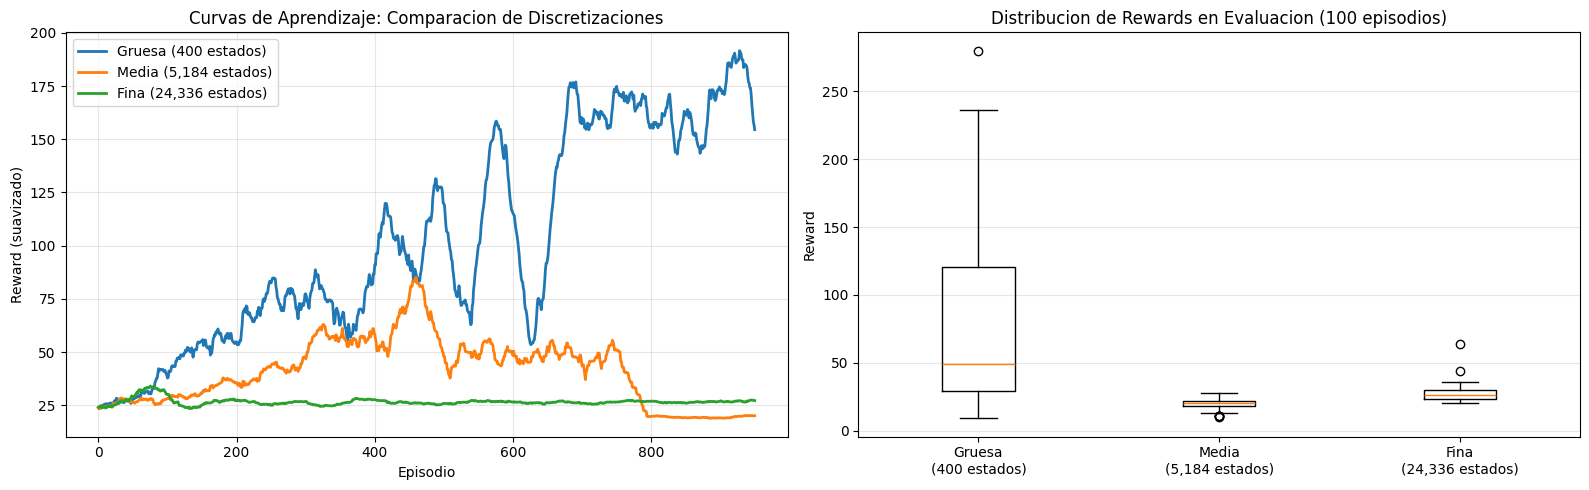


Interpretacion de graficas:
- Izquierda: Muestra como cada discretizacion aprende durante el entrenamiento
- Derecha: Compara la estabilidad y rendimiento final de cada esquema


In [74]:
import matplotlib.pyplot as plt

def smooth_curve(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(smooth_curve(rewards_coarse), label='Gruesa (400 estados)', linewidth=2)
axes[0].plot(smooth_curve(rewards_medium), label='Media (5,184 estados)', linewidth=2)
axes[0].plot(smooth_curve(rewards_fine), label='Fina (24,336 estados)', linewidth=2)
axes[0].set_xlabel('Episodio')
axes[0].set_ylabel('Reward (suavizado)')
axes[0].set_title('Curvas de Aprendizaje: Comparacion de Discretizaciones')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

eval_data = [eval_rewards_coarse, eval_rewards_medium, eval_rewards_fine]
labels = ['Gruesa\n(400 estados)', 'Media\n(5,184 estados)', 'Fina\n(24,336 estados)']
axes[1].boxplot(eval_data, labels=labels)
axes[1].set_ylabel('Reward')
axes[1].set_title('Distribucion de Rewards en Evaluacion (100 episodios)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nInterpretacion de graficas:")
print("- Izquierda: Muestra como cada discretizacion aprende durante el entrenamiento")
print("- Derecha: Compara la estabilidad y rendimiento final de cada esquema")

### Grid Search para Comparacion Justa de Discretizaciones

Usamos **los mismos hiperparametros** para las tres discretizaciones (comparacion equitativa). Solo variamos el numero de episodios segun el tamano del espacio de estados.

**Hiperparametros (IGUALES para todas):**
- Alphas: [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
- Epsilon decay: [0.990, 0.992, 0.995, 0.997, 0.999]
- Gamma: 0.99 (fijo para todas)
- **Total: 7 × 5 = 35 configuraciones por discretizacion**

**Episodios (ajustados al tamano del espacio):**
- **GRUESA (400 estados):** 3,000 episodios
- **MEDIA (5,184 estados):** 10,000 episodios
- **FINA (24,336 estados):** 30,000 episodios


**Estrategia:** Comparacion justa donde cada discretizacion prueba exactamente las mismas combinaciones de hiperparametros. El mejor esquema sera el que logre mayor reward con los mismos parametros.

In [75]:
import time
import pickle
from itertools import product

# MISMAS configuraciones de hiperparametros para TODAS las discretizaciones
# Solo cambian los episodios segun el tamano del espacio de estados
alphas_global = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
epsilon_decays_global = [0.990, 0.992, 0.995, 0.997, 0.999]

grid_configs = [
    {
        'name': 'GRUESA',
        'state_space': state_space_coarse,
        'get_state_fn': get_state_coarse,
        'episodes': 3000,
        'alphas': alphas_global,
        'epsilon_decays': epsilon_decays_global
    },
    {
        'name': 'MEDIA',
        'state_space': state_space_medium,
        'get_state_fn': get_state_medium,
        'episodes': 10000,
        'alphas': alphas_global,
        'epsilon_decays': epsilon_decays_global
    },
    {
        'name': 'FINA',
        'state_space': state_space_fine,
        'get_state_fn': get_state_fine,
        'episodes': 30000,
        'alphas': alphas_global,
        'epsilon_decays': epsilon_decays_global
    }
]

total_configs = sum(
    len(cfg['alphas']) * len(cfg['epsilon_decays']) 
    for cfg in grid_configs
)

print("="*90)
print(f"GRID SEARCH ESTRATIFICADO - {total_configs} configuraciones")
print("="*90)
print(f"Hiperparametros IGUALES para todas: {len(alphas_global)} alphas x {len(epsilon_decays_global)} eps_decay = 35 configs")
print("-"*90)
print("Esquema     | Configs | Episodios | Estados")
print("-"*90)
print(f"GRUESA      |  35     |   3,000   |     400")
print(f"MEDIA       |  35     |  10,000   |   5,184")
print(f"FINA        |  35     |  30,000   |  24,336")
print("-"*90)
print(f"TOTAL       | 105     |           |        ")
print("="*90)
print("\nComparacion JUSTA: Mismos hiperparametros para todas, solo varian episodios")
print("\nSe guardaran checkpoints cada 5 configuraciones en 'grid_results_checkpoint.pkl'")
print("="*90)

grid_results = []
start_time = time.time()
config_idx = 0

for scheme_cfg in grid_configs:
    scheme_name = scheme_cfg['name']
    state_space = scheme_cfg['state_space']
    get_state_fn = scheme_cfg['get_state_fn']
    episodes = scheme_cfg['episodes']
    
    print(f"\n{'='*90}")
    print(f"INICIANDO GRID SEARCH PARA ESQUEMA: {scheme_name}")
    print(f"{'='*90}")
    
    scheme_configs = list(product(
        scheme_cfg['alphas'],
        scheme_cfg['epsilon_decays']
    ))
    
    for alpha, eps_decay in scheme_configs:
        config_idx += 1
        config_start = time.time()
        
        print(f"\n[{config_idx}/{total_configs}] {scheme_name} | alpha={alpha}, eps_decay={eps_decay}, gamma=0.99")
        
        q_table, train_rewards = q_learning_train(
            episodes=episodes,
            alpha=alpha,
            gamma=0.99,
            epsilon_decay=eps_decay,
            get_state_fn=get_state_fn,
            state_space=state_space,
            verbose=False
        )
        
        eval_rewards = evaluate_policy(q_table, get_state_fn, episodes=100, verbose=False)
        
        grid_results.append({
            'scheme': scheme_name,
            'alpha': alpha,
            'epsilon_decay': eps_decay,
            'gamma': 0.99,
            'episodes_trained': episodes,
            'mean_reward': np.mean(eval_rewards),
            'std_reward': np.std(eval_rewards),
            'min_reward': np.min(eval_rewards),
            'max_reward': np.max(eval_rewards),
            'final_100_avg': np.mean(train_rewards[-100:]),
            'q_table': q_table,
            'train_rewards': train_rewards
        })
        
        config_time = time.time() - config_start
        result = grid_results[-1]
        success_marker = "***" if result['mean_reward'] >= 475 else "**" if result['mean_reward'] >= 400 else "*" if result['mean_reward'] >= 300 else ""
        
        print(f"   Evaluacion: {result['mean_reward']:.2f} ± {result['std_reward']:.2f} (max: {result['max_reward']:.0f}) {success_marker}")
        print(f"   Tiempo: {config_time:.1f}s | Final 100 train avg: {result['final_100_avg']:.2f}")
        
        if config_idx % 5 == 0:
            with open('grid_results_checkpoint.pkl', 'wb') as f:
                pickle.dump(grid_results, f)
            elapsed = time.time() - start_time
            avg_time_per_config = elapsed / config_idx
            remaining_configs = total_configs - config_idx
            estimated_remaining = (remaining_configs * avg_time_per_config) / 3600
            print(f"\n   >>> Checkpoint guardado | Progreso: {config_idx}/{total_configs} | Tiempo restante: {estimated_remaining:.2f}h")

total_time = time.time() - start_time
print("\n" + "="*90)
print(f"GRID SEARCH COMPLETADO en {total_time/3600:.2f} horas")
print("="*90)

with open('grid_results_final.pkl', 'wb') as f:
    pickle.dump(grid_results, f)
print("Resultados guardados en 'grid_results_final.pkl'")

GRID SEARCH ESTRATIFICADO - 105 configuraciones
Hiperparametros IGUALES para todas: 7 alphas x 5 eps_decay = 35 configs
------------------------------------------------------------------------------------------
Esquema     | Configs | Episodios | Estados
------------------------------------------------------------------------------------------
GRUESA      |  35     |   3,000   |     400
MEDIA       |  35     |  10,000   |   5,184
FINA        |  35     |  30,000   |  24,336
------------------------------------------------------------------------------------------
TOTAL       | 105     |           |        

Comparacion JUSTA: Mismos hiperparametros para todas, solo varian episodios

Se guardaran checkpoints cada 5 configuraciones en 'grid_results_checkpoint.pkl'

INICIANDO GRID SEARCH PARA ESQUEMA: GRUESA

[1/105] GRUESA | alpha=0.01, eps_decay=0.99, gamma=0.99
   Evaluacion: 74.00 ± 75.39 (max: 371) 
   Tiempo: 8.4s | Final 100 train avg: 63.15

[2/105] GRUESA | alpha=0.01, eps_decay=0

#### Analisis de resultados del Grid Search

In [76]:
df_grid = pd.DataFrame(grid_results)

print("="*100)
print("TOP 10 CONFIGURACIONES")
print("="*100)
top_10 = df_grid.nlargest(10, 'mean_reward')[['scheme', 'alpha', 'epsilon_decay', 'gamma', 'mean_reward', 'std_reward', 'max_reward']]
print(top_10.to_string(index=False))
print("="*100)

print("\n" + "="*100)
print("MEJORES CONFIGURACIONES POR ESQUEMA")
print("="*100)

state_space_map = {
    'GRUESA': np.prod(state_space_coarse),
    'MEDIA': np.prod(state_space_medium),
    'FINA': np.prod(state_space_fine)
}

for scheme_name in ['GRUESA', 'MEDIA', 'FINA']:
    scheme_results = df_grid[df_grid['scheme'] == scheme_name]
    if len(scheme_results) > 0:
        best_config = scheme_results.nlargest(1, 'mean_reward').iloc[0]
        print(f"\n{scheme_name} ({best_config['episodes_trained']} episodios, {state_space_map[scheme_name]} estados):")
        print(f"  Alpha: {best_config['alpha']}, Epsilon decay: {best_config['epsilon_decay']}, Gamma: {best_config['gamma']}")
        print(f"  Reward promedio: {best_config['mean_reward']:.2f} ± {best_config['std_reward']:.2f}")
        print(f"  Max reward: {best_config['max_reward']:.0f}")

print("\n" + "="*100)
print("ESTADISTICAS POR ESQUEMA")
print("="*100)
for scheme_name in ['GRUESA', 'MEDIA', 'FINA']:
    scheme_results = df_grid[df_grid['scheme'] == scheme_name]
    if len(scheme_results) > 0:
        print(f"\n{scheme_name}:")
        print(f"  Configuraciones probadas: {len(scheme_results)}")
        print(f"  Reward promedio (todas configs): {scheme_results['mean_reward'].mean():.2f}")
        print(f"  Mejor reward: {scheme_results['mean_reward'].max():.2f}")
        print(f"  Peor reward: {scheme_results['mean_reward'].min():.2f}")
        print(f"  Configs con reward >= 400: {(scheme_results['mean_reward'] >= 400).sum()}")
        print(f"  Configs con reward >= 475: {(scheme_results['mean_reward'] >= 475).sum()}")
print("="*100)

TOP 10 CONFIGURACIONES
scheme  alpha  epsilon_decay  gamma  mean_reward  std_reward  max_reward
  FINA   0.20          0.990   0.99       500.00    0.000000       500.0
 MEDIA   0.20          0.992   0.99       499.96    0.397995       500.0
  FINA   0.10          0.997   0.99       496.13   20.680742       500.0
 MEDIA   0.05          0.999   0.99       459.49   66.183305       500.0
  FINA   0.10          0.992   0.99       458.35  102.795173       500.0
  FINA   0.15          0.990   0.99       286.80  163.788461       500.0
  FINA   0.25          0.997   0.99       266.29   83.659344       500.0
  FINA   0.05          0.999   0.99       238.21  153.131335       500.0
GRUESA   0.10          0.992   0.99       202.43   43.579411       306.0
GRUESA   0.10          0.995   0.99       199.90   44.231776       319.0

MEJORES CONFIGURACIONES POR ESQUEMA

GRUESA (3000 episodios, 400 estados):
  Alpha: 0.1, Epsilon decay: 0.992, Gamma: 0.99
  Reward promedio: 202.43 ± 43.58
  Max reward: 30

#### Visualizacion de resultados del Grid Search

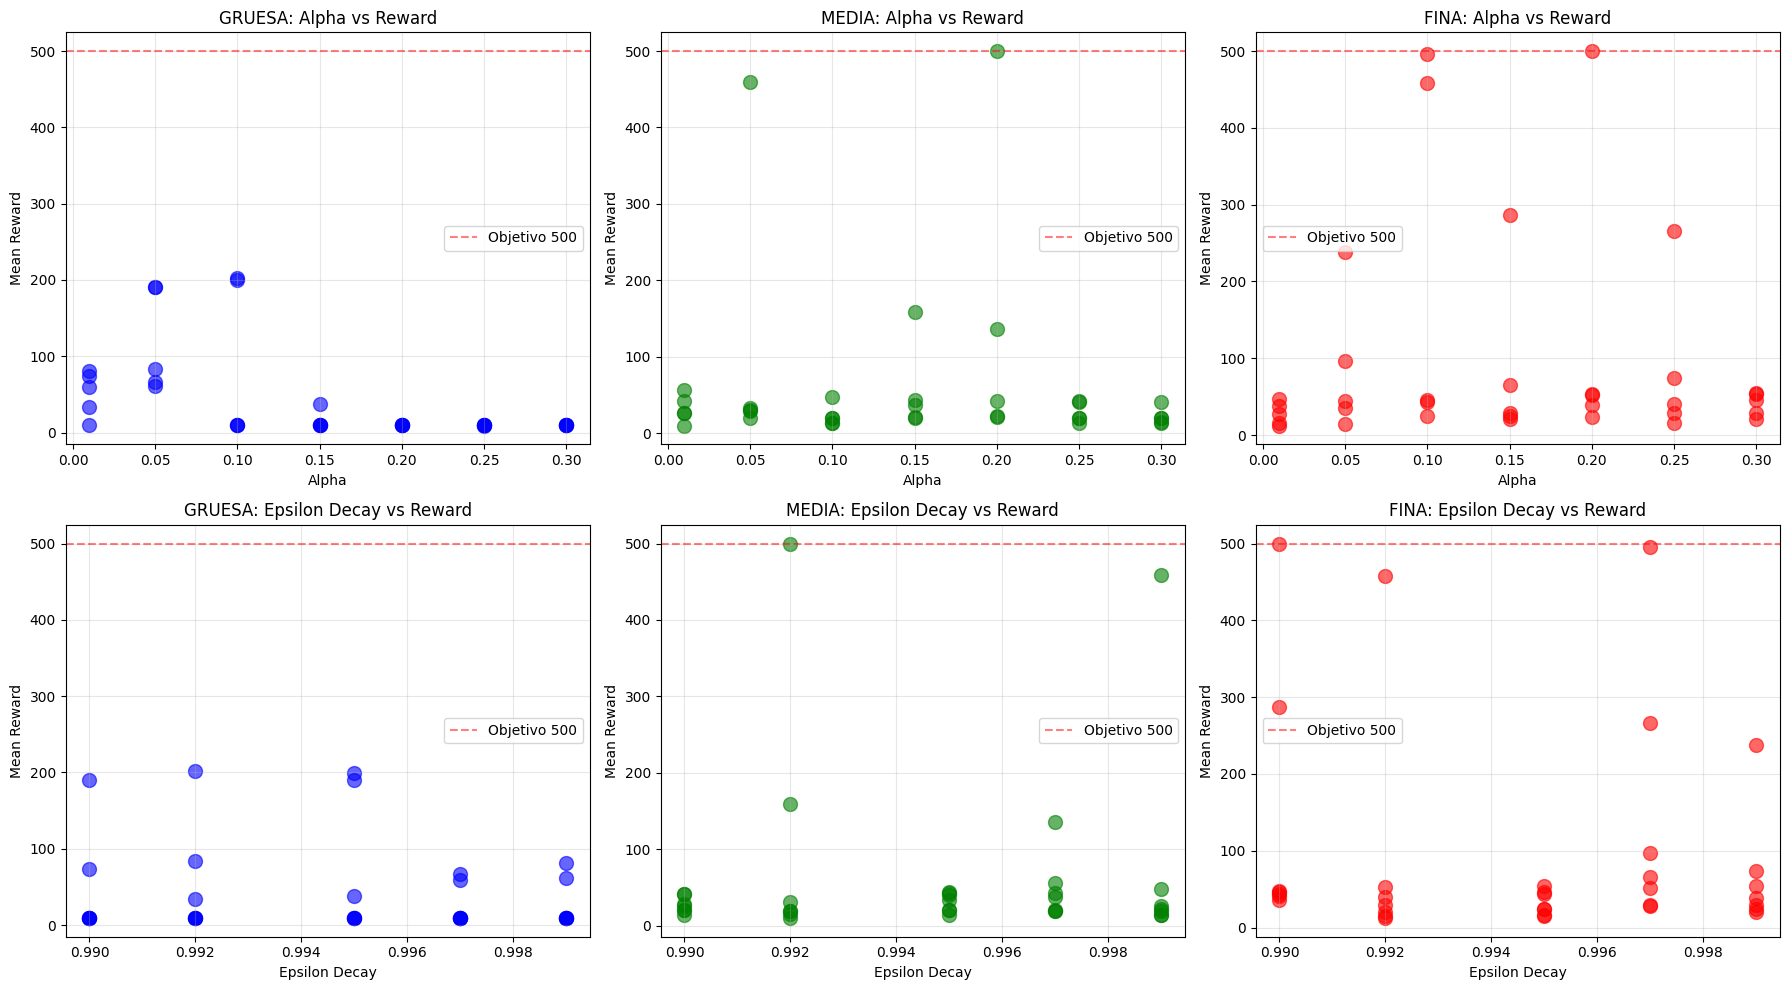


Interpretacion:
- Buscar clusters de puntos en la zona superior
- Identificar rangos optimos de hiperparametros para cada esquema
- Analizar trade-off entre complejidad del estado y rendimiento


In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

schemes = ['GRUESA', 'MEDIA', 'FINA']
colors = {'GRUESA': 'blue', 'MEDIA': 'green', 'FINA': 'red'}

for idx, scheme_name in enumerate(schemes):
    scheme_data = df_grid[df_grid['scheme'] == scheme_name]
    
    if len(scheme_data) > 0:
        axes[0, idx].scatter(scheme_data['alpha'], scheme_data['mean_reward'], 
                             c=[colors[scheme_name]], alpha=0.6, s=100)
        axes[0, idx].set_xlabel('Alpha')
        axes[0, idx].set_ylabel('Mean Reward')
        axes[0, idx].set_title(f'{scheme_name}: Alpha vs Reward')
        axes[0, idx].grid(True, alpha=0.3)
        axes[0, idx].axhline(y=500, color='r', linestyle='--', alpha=0.5, label='Objetivo 500')
        axes[0, idx].legend()
        
        axes[1, idx].scatter(scheme_data['epsilon_decay'], scheme_data['mean_reward'],
                             c=[colors[scheme_name]], alpha=0.6, s=100)
        axes[1, idx].set_xlabel('Epsilon Decay')
        axes[1, idx].set_ylabel('Mean Reward')
        axes[1, idx].set_title(f'{scheme_name}: Epsilon Decay vs Reward')
        axes[1, idx].grid(True, alpha=0.3)
        axes[1, idx].axhline(y=500, color='r', linestyle='--', alpha=0.5, label='Objetivo 500')
        axes[1, idx].legend()

plt.tight_layout()
plt.show()

print("\nInterpretacion:")
print("- Buscar clusters de puntos en la zona superior")
print("- Identificar rangos optimos de hiperparametros para cada esquema")
print("- Analizar trade-off entre complejidad del estado y rendimiento")

#### Heatmaps: Interaccion de hiperparametros

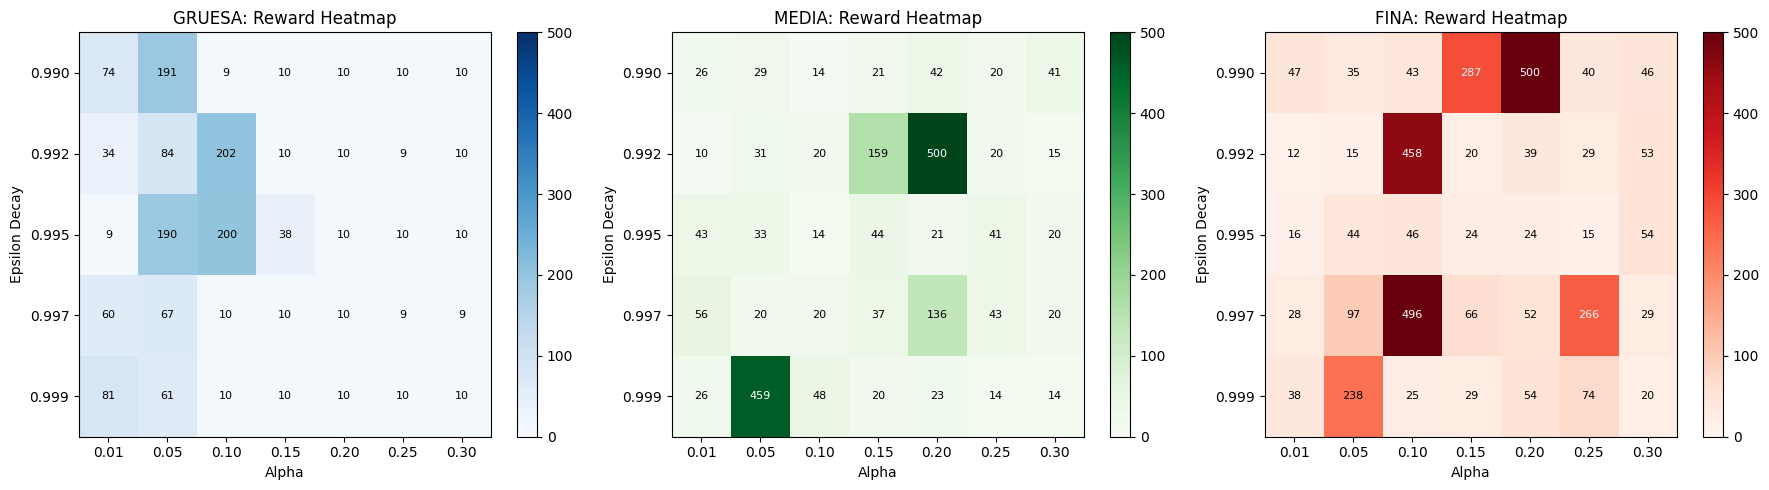


Interpretacion de Heatmaps:
- Colores mas oscuros indican mejores rewards
- Buscar 'zonas calientes' que sugieren combinaciones optimas
- Comparar patrones entre los tres esquemas de discretizacion


In [78]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

schemes = ['GRUESA', 'MEDIA', 'FINA']
colors = {'GRUESA': 'Blues', 'MEDIA': 'Greens', 'FINA': 'Reds'}

for idx, scheme_name in enumerate(schemes):
    scheme_data = df_grid[df_grid['scheme'] == scheme_name]
    
    if len(scheme_data) > 0:
        alphas = sorted(scheme_data['alpha'].unique())
        eps_decays = sorted(scheme_data['epsilon_decay'].unique())
        
        heatmap_data = np.zeros((len(eps_decays), len(alphas)))
        
        for i, eps_decay in enumerate(eps_decays):
            for j, alpha in enumerate(alphas):
                subset = scheme_data[
                    (scheme_data['alpha'] == alpha) & 
                    (scheme_data['epsilon_decay'] == eps_decay)
                ]
                if len(subset) > 0:
                    heatmap_data[i, j] = subset['mean_reward'].max()
        
        im = axes[idx].imshow(heatmap_data, cmap=colors[scheme_name], aspect='auto', 
                              vmin=0, vmax=500, interpolation='nearest')
        axes[idx].set_xticks(range(len(alphas)))
        axes[idx].set_yticks(range(len(eps_decays)))
        axes[idx].set_xticklabels([f'{a:.2f}' for a in alphas])
        axes[idx].set_yticklabels([f'{ed:.3f}' for ed in eps_decays])
        axes[idx].set_xlabel('Alpha')
        axes[idx].set_ylabel('Epsilon Decay')
        axes[idx].set_title(f'{scheme_name}: Reward Heatmap')
        
        for i in range(len(eps_decays)):
            for j in range(len(alphas)):
                value = heatmap_data[i, j]
                if value > 0:
                    text_color = 'white' if value > 250 else 'black'
                    axes[idx].text(j, i, f'{value:.0f}', 
                                  ha='center', va='center', color=text_color, fontsize=8)
        
        plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

print("\nInterpretacion de Heatmaps:")
print("- Colores mas oscuros indican mejores rewards")
print("- Buscar 'zonas calientes' que sugieren combinaciones optimas")
print("- Comparar patrones entre los tres esquemas de discretizacion")


## FASE 4: Stochastic Q-learning

**Objetivo:**

Implementar y comparar Stochastic Q-learning con Q-learning clásico en CartPole-v1. El algoritmo estocástico reemplaza las operaciones argmax y max sobre todas las acciones por operaciones sobre un subconjunto aleatorio de tamaño k = ⌈log(n)⌉, reduciendo la complejidad de O(n) a O(log n).

**Adaptación al contexto**

Aunque CartPole tiene solo 2 acciones (donde log(2)=1), esta implementación está generalizada para entornos con mayor número de acciones. El código incluye:
- **Muestreo aleatorio:** Subconjunto R de tamaño k
- **Memoria de acciones explotadas:** Conjunto M de acciones previamente exitosas
- **Conjunto candidato:** C = R ∪ M (unión de muestreo + memoria)


### Implementación de la Clase StochasticQLearningAgent

In [2]:
import math
from collections import defaultdict, deque

class StochasticQLearningAgent:
    """
    Implementación de Stochastic Q-learning según Fourati et al. (2024).
    
    Reemplaza argmax/max clásicos sobre TODAS las acciones por operaciones
    sobre un subconjunto aleatorio de tamaño k = ceil(log(n_actions)).
    
    Componentes clave:
    - stoch_argmax: Selecciona mejor acción de un subconjunto C = R ∪ M
    - stoch_max: Calcula max Q-value sobre el subconjunto C
    - Memoria M: Registra acciones exitosas previamente explotadas
    - Conjunto aleatorio R: Muestreo sin reemplazo de tamaño k
    """
    
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay_episodes=1000,
                 use_memory=True, memory_size_per_state=2):
        """
        Args:
            n_states: Número total de estados discretos
            n_actions: Número de acciones disponibles
            alpha: Tasa de aprendizaje
            gamma: Factor de descuento
            epsilon_start: Epsilon inicial para exploración
            epsilon_end: Epsilon final (mínimo)
            epsilon_decay_episodes: Episodios para decay lineal de epsilon
            use_memory: Si True, usa memoria M de acciones explotadas
            memory_size_per_state: Tamaño máximo de memoria por estado
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        
        # Epsilon-greedy con decaimiento lineal
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_episodes = epsilon_decay_episodes
        
        # Q-table: shape (n_states, n_actions)
        self.Q = np.zeros((n_states, n_actions))
        
        # Sistema de memoria: guarda acciones explotadas exitosas por estado
        self.use_memory = use_memory
        self.memory_size_per_state = memory_size_per_state
        # Usar dict normal en lugar de defaultdict para ser pickle-compatible
        self.memory = {}
    
    def _epsilon(self, episode_idx):
        """
        Calcula epsilon para el episodio actual con decaimiento lineal.
        
        Args:
            episode_idx: Índice del episodio actual (0-indexed)
        
        Returns:
            Valor de epsilon en [epsilon_end, epsilon_start]
        """
        if episode_idx >= self.epsilon_decay_episodes:
            return self.epsilon_end
        
        # Decaimiento lineal: epsilon_start -> epsilon_end en epsilon_decay_episodes
        decay_fraction = episode_idx / self.epsilon_decay_episodes
        epsilon = self.epsilon_start - (self.epsilon_start - self.epsilon_end) * decay_fraction
        return max(self.epsilon_end, epsilon)
    
    def _sample_candidate_actions(self, state_idx):
        """
        Construye el conjunto candidato C = R ∪ M según el paper.
        
        R: Subconjunto aleatorio de tamaño k = ceil(log(n_actions))
        M: Acciones en memoria para este estado (si use_memory=True)
        C: Unión de R y M (sin duplicados)
        
        Args:
            state_idx: Índice del estado actual
        
        Returns:
            np.ndarray con índices de acciones candidatas
        """
        # Tamaño del subconjunto aleatorio: k = ceil(log(n_actions))
        k = max(1, math.ceil(math.log(self.n_actions)))
        
        # Muestreo aleatorio R de tamaño k (sin reemplazo)
        R = np.random.choice(self.n_actions, size=min(k, self.n_actions), replace=False)
        
        if not self.use_memory:
            return R
        
        # Obtener memoria M para este estado (inicializar si no existe)
        if state_idx not in self.memory:
            self.memory[state_idx] = deque(maxlen=self.memory_size_per_state)
        M = list(self.memory[state_idx])
        
        # C = R ∪ M (unión sin duplicados)
        C = np.unique(np.concatenate([R, M]))
        
        return C.astype(int)
    
    def stoch_argmax(self, state_idx):
        """
        Selecciona la mejor acción usando stochastic argmax del paper.
        
        En lugar de argmax sobre TODAS las acciones, considera solo
        el subconjunto candidato C = R ∪ M. Desempata aleatoriamente.
        
        Args:
            state_idx: Índice del estado actual
        
        Returns:
            Índice de la acción seleccionada
        """
        C = self._sample_candidate_actions(state_idx)
        
        # Q-values del subconjunto candidato
        q_values = self.Q[state_idx, C]
        
        # Valor máximo en el subconjunto
        max_q = np.max(q_values)
        
        # Desempate aleatorio entre acciones con max Q-value
        best_actions_in_C = C[q_values == max_q]
        action = np.random.choice(best_actions_in_C)
        
        return int(action)
    
    def stoch_max(self, state_idx):
        """
        Calcula el max Q-value usando stochastic max del paper.
        
        En lugar de max sobre TODAS las acciones, considera solo
        el subconjunto candidato C = R ∪ M.
        
        Args:
            state_idx: Índice del estado actual
        
        Returns:
            Max Q-value en el subconjunto C
        """
        C = self._sample_candidate_actions(state_idx)
        return np.max(self.Q[state_idx, C])
    
    def select_action(self, state_idx, episode_idx):
        """
        Selecciona acción usando epsilon-greedy con stoch_argmax.
        
        - Con probabilidad epsilon: acción aleatoria (exploración)
        - Con probabilidad 1-epsilon: stoch_argmax (explotación)
        
        Si se explota y use_memory=True, guarda la acción en memoria.
        
        Args:
            state_idx: Índice del estado actual
            episode_idx: Índice del episodio (para calcular epsilon)
        
        Returns:
            Índice de la acción seleccionada
        """
        epsilon = self._epsilon(episode_idx)
        
        # Exploración: acción aleatoria
        if np.random.random() < epsilon:
            action = np.random.randint(0, self.n_actions)
            return action
        
        # Explotación: stoch_argmax
        action = self.stoch_argmax(state_idx)
        
        # Guardar en memoria si está habilitada
        if self.use_memory:
            if state_idx not in self.memory:
                self.memory[state_idx] = deque(maxlen=self.memory_size_per_state)
            self.memory[state_idx].append(action)
        
        return action
    
    def update(self, state_idx, action, reward, next_state_idx, done):
        """
        Actualización de Q-learning usando stoch_max para el bootstrap.
        
        Q(s,a) += alpha * [reward + gamma * stoch_max(s') - Q(s,a)]
        
        Args:
            state_idx: Índice del estado actual
            action: Acción ejecutada
            reward: Recompensa recibida
            next_state_idx: Índice del siguiente estado
            done: Si el episodio terminó
        """
        if done:
            target = reward
        else:
            target = reward + self.gamma * self.stoch_max(next_state_idx)
        
        td_error = target - self.Q[state_idx, action]
        self.Q[state_idx, action] += self.alpha * td_error

print("Clase StochasticQLearningAgent implementada exitosamente.")
print(f"- Complejidad stoch_argmax/stoch_max: O(log n) vs O(n) clásico")
print(f"- Memoria de acciones: Mejora exploración al recordar acciones exitosas")
print(f"- Generalizada para cualquier número de acciones (CartPole tiene 2)")

Clase StochasticQLearningAgent implementada exitosamente.
- Complejidad stoch_argmax/stoch_max: O(log n) vs O(n) clásico
- Memoria de acciones: Mejora exploración al recordar acciones exitosas
- Generalizada para cualquier número de acciones (CartPole tiene 2)


### Función de Entrenamiento para Stochastic Q-learning

In [3]:
def train_stochastic_q(env, agent, get_state_fn, state_space, n_episodes, 
                       max_steps_per_episode=500, verbose=True):
    """
    Entrena un agente Stochastic Q-learning en el entorno CartPole.
    
    Diferencia clave con q_learning_train():
    - Usa StochasticQLearningAgent (con stoch_argmax/stoch_max)
    - Convierte estados tuple (i,j,k,l) a índice plano con np.ravel_multi_index
    - La Q-table del agente es shape (n_states, n_actions) en lugar de multi-índice
    
    Args:
        env: Entorno de Gymnasium (CartPole-v1)
        agent: Instancia de StochasticQLearningAgent
        get_state_fn: Función que convierte observación a tuple de índices
        state_space: Tuple con dimensiones del espacio de estados (e.g., (4,5,5,4))
        n_episodes: Número de episodios de entrenamiento
        max_steps_per_episode: Límite de pasos por episodio
        verbose: Si True, imprime progreso cada 100 episodios
    
    Returns:
        rewards_per_episode: Lista con recompensas acumuladas por episodio
    """
    rewards_per_episode = []
    
    for episode in range(n_episodes):
        # Reset del entorno
        obs, _ = env.reset()
        state_tuple = get_state_fn(obs)
        
        # Convertir tuple de índices (i,j,k,l) a índice plano
        state_idx = np.ravel_multi_index(state_tuple, state_space)
        
        episode_reward = 0
        steps = 0
        done = False
        
        while not done and steps < max_steps_per_episode:
            # Seleccionar acción con epsilon-greedy + stoch_argmax
            action = agent.select_action(state_idx, episode)
            
            # Ejecutar acción en el entorno
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Convertir siguiente observación a índice plano
            next_state_tuple = get_state_fn(next_obs)
            next_state_idx = np.ravel_multi_index(next_state_tuple, state_space)
            
            # Actualizar Q-table con stoch_max
            agent.update(state_idx, action, reward, next_state_idx, done)
            
            # Avanzar al siguiente estado
            state_idx = next_state_idx
            episode_reward += reward
            steps += 1
        
        rewards_per_episode.append(episode_reward)
        
        # Logging de progreso
        if verbose and (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            epsilon_current = agent._epsilon(episode)
            print(f"Episodio {episode + 1}/{n_episodes} - "
                  f"Recompensa promedio (últimos 100): {avg_reward:.2f} - "
                  f"Epsilon: {epsilon_current:.4f}")
    
    return rewards_per_episode

print("Función train_stochastic_q() implementada exitosamente.")
print("- Convierte estados multi-índice a índice plano con np.ravel_multi_index")
print("- Compatible con las funciones get_state_coarse/medium/fine existentes")
print("- Usa métodos del agente: select_action(), update() con stoch_max")

Función train_stochastic_q() implementada exitosamente.
- Convierte estados multi-índice a índice plano con np.ravel_multi_index
- Compatible con las funciones get_state_coarse/medium/fine existentes
- Usa métodos del agente: select_action(), update() con stoch_max


### Grid Search para Stochastic Q-learning

Realizamos un Grid Search exhaustivo igual que en la Fase 3, pero ahora para **Stochastic Q-learning**.

**Hiperparámetros explorados (IGUALES para todas las discretizaciones):**
- Alphas: [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3] (7 valores)
- Epsilon decay: [0.990, 0.992, 0.995, 0.997, 0.999] (5 valores)
- Gamma: 0.99 (fijo)
- **use_memory: [True, False]** (2 valores - NUEVO)
- **memory_size_per_state: [1, 2]** (2 valores - NUEVO)

**Total: 7 × 5 × 2 × 2 = 140 configuraciones por discretización**

**Episodios (IGUALES a Fase 3):**
- **GRUESA (400 estados):** 3,000 episodios
- **MEDIA (5,184 estados):** 10,000 episodios
- **FINA (24,336 estados):** 30,000 episodios

**Total general: 140 × 3 = 420 configuraciones**

**Estrategia:** Comparación justa con Q-learning clásico. Los únicos parámetros nuevos son `use_memory` y `memory_size`, que son específicos del algoritmo estocástico.

### CELDA DE RECUPERACIÓN RÁPIDA

**Si el kernel se reinició y perdiste las variables, ejecuta la celda siguiente para restaurar todo lo necesario:**

In [22]:
# ============================================================================
# CELDA DE RECUPERACIÓN RÁPIDA - Ejecuta esto si el kernel se reinició
# ============================================================================

import gymnasium as gym
import numpy as np
import random

# Crear entorno
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Definir discretizaciones (copia de las celdas 23, 25, 27)
bins_coarse = {
    'cart_position': np.linspace(-4.8, 4.8, 3),
    'cart_velocity': np.linspace(-4, 4, 4),
    'pole_angle': np.linspace(-0.418, 0.418, 4),
    'pole_angular_velocity': np.linspace(-4, 4, 3)
}

bins_medium = {
    'cart_position': np.linspace(-4.8, 4.8, 7),
    'cart_velocity': np.linspace(-4, 4, 7),
    'pole_angle': np.linspace(-0.418, 0.418, 8),
    'pole_angular_velocity': np.linspace(-4, 4, 8)
}

bins_fine = {
    'cart_position': np.linspace(-4.8, 4.8, 11),
    'cart_velocity': np.linspace(-4, 4, 11),
    'pole_angle': np.linspace(-0.418, 0.418, 12),
    'pole_angular_velocity': np.linspace(-4, 4, 12)
}

# Funciones de discretización
def get_state_coarse(obs):
    cart_pos_idx = np.digitize(obs[0], bins_coarse['cart_position'])
    cart_vel_idx = np.digitize(obs[1], bins_coarse['cart_velocity'])
    pole_angle_idx = np.digitize(obs[2], bins_coarse['pole_angle'])
    pole_ang_vel_idx = np.digitize(obs[3], bins_coarse['pole_angular_velocity'])
    return (cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx)

def get_state_medium(obs):
    cart_pos_idx = np.digitize(obs[0], bins_medium['cart_position'])
    cart_vel_idx = np.digitize(obs[1], bins_medium['cart_velocity'])
    pole_angle_idx = np.digitize(obs[2], bins_medium['pole_angle'])
    pole_ang_vel_idx = np.digitize(obs[3], bins_medium['pole_angular_velocity'])
    return (cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx)

def get_state_fine(obs):
    cart_pos_idx = np.digitize(obs[0], bins_fine['cart_position'])
    cart_vel_idx = np.digitize(obs[1], bins_fine['cart_velocity'])
    pole_angle_idx = np.digitize(obs[2], bins_fine['pole_angle'])
    pole_ang_vel_idx = np.digitize(obs[3], bins_fine['pole_angular_velocity'])
    return (cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx)

# Espacios de estados
state_space_coarse = (len(bins_coarse['cart_position']) + 1,
                      len(bins_coarse['cart_velocity']) + 1,
                      len(bins_coarse['pole_angle']) + 1,
                      len(bins_coarse['pole_angular_velocity']) + 1)

state_space_medium = (len(bins_medium['cart_position']) + 1,
                      len(bins_medium['cart_velocity']) + 1,
                      len(bins_medium['pole_angle']) + 1,
                      len(bins_medium['pole_angular_velocity']) + 1)

state_space_fine = (len(bins_fine['cart_position']) + 1,
                    len(bins_fine['cart_velocity']) + 1,
                    len(bins_fine['pole_angle']) + 1,
                    len(bins_fine['pole_angular_velocity']) + 1)

# Función evaluate_policy (de celda 36)
def evaluate_policy(q_table, get_state_fn, episodes=100, verbose=True):
    total_rewards = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = get_state_fn(state)
        
        episode_reward = 0
        done = False
        
        while not done:
            action = np.argmax(q_table[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = get_state_fn(next_state)
            episode_reward += reward
        
        total_rewards.append(episode_reward)
    
    if verbose:
        print(f"\nEvaluación completa: {episodes} episodios")
        print(f"Recompensa promedio: {np.mean(total_rewards):.2f}")
        print(f"Desviación estándar: {np.std(total_rewards):.2f}")
        print(f"Recompensa mínima: {np.min(total_rewards):.2f}")
        print(f"Recompensa máxima: {np.max(total_rewards):.2f}")
    
    return total_rewards

print("Variables restauradas exitosamente:")
print(f"   - env: {env}")
print(f"   - state_space_coarse: {state_space_coarse} = {np.prod(state_space_coarse)} estados")
print(f"   - state_space_medium: {state_space_medium} = {np.prod(state_space_medium)} estados")
print(f"   - state_space_fine: {state_space_fine} = {np.prod(state_space_fine)} estados")
print(f"   - Funciones: get_state_coarse/medium/fine, evaluate_policy")
print("\nAhora puedes ejecutar el Grid Search")

Variables restauradas exitosamente:
   - env: <TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>
   - state_space_coarse: (4, 5, 5, 4) = 400 estados
   - state_space_medium: (8, 8, 9, 9) = 5184 estados
   - state_space_fine: (12, 12, 13, 13) = 24336 estados
   - Funciones: get_state_coarse/medium/fine, evaluate_policy

Ahora puedes ejecutar el Grid Search


In [7]:
import time
import pickle
from itertools import product

# MISMAS configuraciones de hiperparámetros para TODAS las discretizaciones
# AGREGAMOS: use_memory y memory_size_per_state
alphas_stoch = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
epsilon_decays_stoch = [0.990, 0.992, 0.995, 0.997, 0.999]
use_memory_options = [True, False]
memory_size_options = [1, 2]

grid_configs_stoch = [
    {
        'name': 'GRUESA',
        'state_space': state_space_coarse,
        'get_state_fn': get_state_coarse,
        'episodes': 3000,
        'alphas': alphas_stoch,
        'epsilon_decays': epsilon_decays_stoch,
        'use_memory_options': use_memory_options,
        'memory_size_options': memory_size_options
    },
    {
        'name': 'MEDIA',
        'state_space': state_space_medium,
        'get_state_fn': get_state_medium,
        'episodes': 10000,
        'alphas': alphas_stoch,
        'epsilon_decays': epsilon_decays_stoch,
        'use_memory_options': use_memory_options,
        'memory_size_options': memory_size_options
    },
    {
        'name': 'FINA',
        'state_space': state_space_fine,
        'get_state_fn': get_state_fine,
        'episodes': 30000,
        'alphas': alphas_stoch,
        'epsilon_decays': epsilon_decays_stoch,
        'use_memory_options': use_memory_options,
        'memory_size_options': memory_size_options
    }
]

total_configs_stoch = sum(
    len(cfg['alphas']) * len(cfg['epsilon_decays']) * len(cfg['use_memory_options']) * len(cfg['memory_size_options'])
    for cfg in grid_configs_stoch
)

print("="*90)
print(f"GRID SEARCH STOCHASTIC Q-LEARNING - {total_configs_stoch} configuraciones")
print("="*90)
print(f"Hiperparámetros base: {len(alphas_stoch)} alphas x {len(epsilon_decays_stoch)} eps_decay = 35")
print(f"Parámetros estocásticos: {len(use_memory_options)} use_memory x {len(memory_size_options)} memory_size = 4")
print(f"Total por esquema: 35 x 4 = 140 configuraciones")
print("-"*90)
print("Esquema     | Configs | Episodios | Estados")
print("-"*90)
print(f"GRUESA      |  140    |   3,000   |     400")
print(f"MEDIA       |  140    |  10,000   |   5,184")
print(f"FINA        |  140    |  30,000   |  24,336")
print("-"*90)
print(f"TOTAL       |  420    |           |        ")
print("="*90)
print("\nComparación JUSTA con Fase 3: Mismos hiperparámetros base, explorando use_memory y memory_size")
print("\nSe guardarán checkpoints cada 5 configuraciones en 'grid_results_stoch_checkpoint.pkl'")
print("="*90)

# CHECKPOINT RECOVERY: Cargar progreso previo si existe
import os
checkpoint_file = 'grid_results_stoch_checkpoint.pkl'
if os.path.exists(checkpoint_file):
    print("\n CHECKPOINT DETECTADO - Cargando progreso previo...")
    with open(checkpoint_file, 'rb') as f:
        grid_results_stoch = pickle.load(f)
    total_completed = len(grid_results_stoch)
    
    # Determinar cuántas configs de cada esquema ya están completas
    configs_per_scheme = 140  # 7 alphas × 5 eps_decay × 2 use_memory × 2 memory_size
    completed_by_scheme = {
        'GRUESA': min(total_completed, configs_per_scheme),
        'MEDIA': min(max(0, total_completed - configs_per_scheme), configs_per_scheme),
        'FINA': max(0, total_completed - 2*configs_per_scheme)
    }
    
    print(f"Checkpoint cargado: {total_completed}/{total_configs_stoch} configs ({total_completed/total_configs_stoch*100:.1f}%)")
    print(f"   GRUESA: {completed_by_scheme['GRUESA']}/140 {'COMPLETO' if completed_by_scheme['GRUESA'] == 140 else 'PAUSADO'}")
    print(f"   MEDIA:  {completed_by_scheme['MEDIA']}/140 {'COMPLETO' if completed_by_scheme['MEDIA'] == 140 else 'PAUSADO'}")
    print(f"   FINA:   {completed_by_scheme['FINA']}/140 {'FALTAN ' + str(140 - completed_by_scheme['FINA']) if completed_by_scheme['FINA'] < 140 else 'COMPLETO'}")
    print(f"Resumiendo desde configuracion #{total_completed + 1}")
    print("="*90)
else:
    print("\n Iniciando Grid Search desde cero...")
    grid_results_stoch = []
    total_completed = 0
    completed_by_scheme = {'GRUESA': 0, 'MEDIA': 0, 'FINA': 0}

start_time = time.time()
config_idx = total_completed  # Contador global de configuraciones

for scheme_cfg in grid_configs_stoch:
    scheme_name = scheme_cfg['name']
    state_space = scheme_cfg['state_space']
    get_state_fn = scheme_cfg['get_state_fn']
    episodes = scheme_cfg['episodes']
    
    # Determinar cuántas configs de este esquema ya están completas
    scheme_completed = completed_by_scheme[scheme_name]
    
    # Si este esquema ya está completo, saltar completamente
    if scheme_completed >= 140:
        print(f"\n{'='*90}")
        print(f"ESQUEMA {scheme_name} YA COMPLETADO ({scheme_completed}/140 configs) - SALTANDO")
        print(f"{'='*90}")
        continue
    
    print(f"\n{'='*90}")
    print(f"{'RESUMIENDO' if scheme_completed > 0 else 'INICIANDO'} GRID SEARCH PARA ESQUEMA: {scheme_name}")
    if scheme_completed > 0:
        print(f"   Ya completadas: {scheme_completed}/140 configs")
        print(f"   Por ejecutar: {140 - scheme_completed} configs")
    print(f"{'='*90}")
    
    # Producto cartesiano de todas las configuraciones
    scheme_configs = list(product(
        scheme_cfg['alphas'],
        scheme_cfg['epsilon_decays'],
        scheme_cfg['use_memory_options'],
        scheme_cfg['memory_size_options']
    ))
    
    # Iterar sobre las configuraciones de este esquema
    for scheme_config_idx, (alpha, eps_decay, use_memory, memory_size) in enumerate(scheme_configs):
        # SKIP si esta configuración del esquema ya fue completada
        if scheme_config_idx < scheme_completed:
            continue
        
        config_idx += 1
        config_start = time.time()
        
        print(f"\n[{config_idx}/{total_configs_stoch}] {scheme_name} (#{scheme_config_idx + 1}/140) | "
              f"alpha={alpha}, eps_decay={eps_decay}, use_memory={use_memory}, memory_size={memory_size}")
        
        # Instanciar agente con configuración específica
        n_states = np.prod(state_space)
        agent = StochasticQLearningAgent(
            n_states=n_states,
            n_actions=env.action_space.n,
            alpha=alpha,
            gamma=0.99,
            epsilon_start=1.0,
            epsilon_end=0.01,
            epsilon_decay_episodes=episodes,
            use_memory=use_memory,
            memory_size_per_state=memory_size
        )
        
        # Entrenar
        train_rewards = train_stochastic_q(
            env=env,
            agent=agent,
            get_state_fn=get_state_fn,
            state_space=state_space,
            n_episodes=episodes,
            max_steps_per_episode=500,
            verbose=False
        )
        
        # Evaluar política aprendida
        q_table_multi = agent.Q.reshape((*state_space, env.action_space.n))
        eval_rewards = evaluate_policy(q_table_multi, get_state_fn, episodes=100, verbose=False)
        
        # Guardar resultados (sin el agente completo para evitar problemas de pickle)
        grid_results_stoch.append({
            'scheme': scheme_name,
            'alpha': alpha,
            'epsilon_decay': eps_decay,
            'gamma': 0.99,
            'use_memory': use_memory,
            'memory_size': memory_size,
            'episodes_trained': episodes,
            'mean_reward': np.mean(eval_rewards),
            'std_reward': np.std(eval_rewards),
            'min_reward': np.min(eval_rewards),
            'max_reward': np.max(eval_rewards),
            'final_100_avg': np.mean(train_rewards[-100:]),
            'q_table': agent.Q.copy(),  # Solo guardar la Q-table
            'train_rewards': train_rewards
        })
        
        config_time = time.time() - config_start
        result = grid_results_stoch[-1]
        success_marker = "***" if result['mean_reward'] >= 475 else "**" if result['mean_reward'] >= 400 else "*" if result['mean_reward'] >= 300 else ""
        
        print(f"   Evaluación: {result['mean_reward']:.2f} ± {result['std_reward']:.2f} (max: {result['max_reward']:.0f}) {success_marker}")
        print(f"   Tiempo: {config_time:.1f}s | Final 100 train avg: {result['final_100_avg']:.2f}")
        
        # Checkpoint cada 5 configuraciones
        if config_idx % 5 == 0:
            with open('grid_results_stoch_checkpoint.pkl', 'wb') as f:
                pickle.dump(grid_results_stoch, f)
            elapsed = time.time() - start_time
            configs_executed_now = config_idx - total_completed
            avg_time_per_config = elapsed / configs_executed_now if configs_executed_now > 0 else 0
            remaining_configs = total_configs_stoch - config_idx
            estimated_remaining = (remaining_configs * avg_time_per_config) / 3600
            print(f"\n   >>> Checkpoint guardado | Progreso: {config_idx}/{total_configs_stoch} | Tiempo restante estimado: {estimated_remaining:.2f}h")

total_time = time.time() - start_time
print("\n" + "="*90)
print(f"GRID SEARCH STOCHASTIC Q-LEARNING COMPLETADO en {total_time/3600:.2f} horas")
print("="*90)

# Guardar resultados finales
with open('grid_results_stoch_final.pkl', 'wb') as f:
    pickle.dump(grid_results_stoch, f)
print("Resultados guardados en 'grid_results_stoch_final.pkl'")

GRID SEARCH STOCHASTIC Q-LEARNING - 420 configuraciones
Hiperparámetros base: 7 alphas x 5 eps_decay = 35
Parámetros estocásticos: 2 use_memory x 2 memory_size = 4
Total por esquema: 35 x 4 = 140 configuraciones
------------------------------------------------------------------------------------------
Esquema     | Configs | Episodios | Estados
------------------------------------------------------------------------------------------
GRUESA      |  140    |   3,000   |     400
MEDIA       |  140    |  10,000   |   5,184
FINA        |  140    |  30,000   |  24,336
------------------------------------------------------------------------------------------
TOTAL       |  420    |           |        

Comparación JUSTA con Fase 3: Mismos hiperparámetros base, explorando use_memory y memory_size

Se guardarán checkpoints cada 5 configuraciones en 'grid_results_stoch_checkpoint.pkl'

 CHECKPOINT DETECTADO - Cargando progreso previo...
 Checkpoint cargado: 400/420 configs (95.2%)
   GRUESA: 14

### Análisis de Resultados: Stochastic Q-learning

In [8]:
import pandas as pd

df_grid_stoch = pd.DataFrame(grid_results_stoch)

print("="*120)
print("TOP 10 CONFIGURACIONES - STOCHASTIC Q-LEARNING")
print("="*120)
top_10_stoch = df_grid_stoch.nlargest(10, 'mean_reward')[
    ['scheme', 'alpha', 'epsilon_decay', 'use_memory', 'memory_size', 'mean_reward', 'std_reward', 'max_reward']
]
print(top_10_stoch.to_string(index=False))
print("="*120)

print("\n" + "="*120)
print("MEJORES CONFIGURACIONES POR ESQUEMA - STOCHASTIC Q-LEARNING")
print("="*120)

state_space_map_stoch = {
    'GRUESA': np.prod(state_space_coarse),
    'MEDIA': np.prod(state_space_medium),
    'FINA': np.prod(state_space_fine)
}

for scheme_name in ['GRUESA', 'MEDIA', 'FINA']:
    scheme_results = df_grid_stoch[df_grid_stoch['scheme'] == scheme_name]
    if len(scheme_results) > 0:
        best_config = scheme_results.nlargest(1, 'mean_reward').iloc[0]
        print(f"\n{scheme_name} ({best_config['episodes_trained']} episodios, {state_space_map_stoch[scheme_name]} estados):")
        print(f"  Alpha: {best_config['alpha']}, Epsilon decay: {best_config['epsilon_decay']}, Gamma: {best_config['gamma']}")
        print(f"  Use memory: {best_config['use_memory']}, Memory size: {best_config['memory_size']}")
        print(f"  Reward promedio: {best_config['mean_reward']:.2f} ± {best_config['std_reward']:.2f}")
        print(f"  Max reward: {best_config['max_reward']:.0f}")

print("\n" + "="*120)
print("ESTADÍSTICAS POR ESQUEMA - STOCHASTIC Q-LEARNING")
print("="*120)
for scheme_name in ['GRUESA', 'MEDIA', 'FINA']:
    scheme_results = df_grid_stoch[df_grid_stoch['scheme'] == scheme_name]
    if len(scheme_results) > 0:
        print(f"\n{scheme_name}:")
        print(f"  Configuraciones probadas: {len(scheme_results)}")
        print(f"  Reward promedio (todas configs): {scheme_results['mean_reward'].mean():.2f}")
        print(f"  Mejor reward: {scheme_results['mean_reward'].max():.2f}")
        print(f"  Peor reward: {scheme_results['mean_reward'].min():.2f}")
        print(f"  Configs con reward >= 400: {(scheme_results['mean_reward'] >= 400).sum()}")
        print(f"  Configs con reward >= 475: {(scheme_results['mean_reward'] >= 475).sum()}")
        
        # Análisis del impacto de use_memory
        with_memory = scheme_results[scheme_results['use_memory'] == True]
        without_memory = scheme_results[scheme_results['use_memory'] == False]
        if len(with_memory) > 0 and len(without_memory) > 0:
            print(f"  Reward promedio CON memoria: {with_memory['mean_reward'].mean():.2f}")
            print(f"  Reward promedio SIN memoria: {without_memory['mean_reward'].mean():.2f}")
            improvement = with_memory['mean_reward'].mean() - without_memory['mean_reward'].mean()
            print(f"  Mejora con memoria: {improvement:+.2f} ({improvement/without_memory['mean_reward'].mean()*100:+.2f}%)")

print("="*120)

TOP 10 CONFIGURACIONES - STOCHASTIC Q-LEARNING
scheme  alpha  epsilon_decay  use_memory  memory_size  mean_reward  std_reward  max_reward
  FINA   0.25          0.999        True            1       500.00    0.000000       500.0
  FINA   0.01          0.992        True            1       498.68    7.820332       500.0
  FINA   0.01          0.995        True            1       498.52   14.725814       500.0
 MEDIA   0.05          0.999        True            2       496.28   11.200964       500.0
  FINA   0.01          0.990        True            1       491.49   21.304692       500.0
 MEDIA   0.10          0.992        True            2       478.37   41.699078       500.0
 MEDIA   0.20          0.999        True            1       477.96   49.176197       500.0
 MEDIA   0.05          0.990        True            1       472.03   47.372240       500.0
  FINA   0.10          0.999        True            1       470.92   59.119655       500.0
  FINA   0.01          0.999        True   

### Comparación Gráfica: Q-learning Clásico vs Stochastic Q-learning

Comparamos los mejores resultados de cada esquema entre Q-learning clásico (Fase 3) y Stochastic Q-learning (Fase 4).

In [10]:
# Cargar resultados del Grid Search Clásico (Fase 3) para comparación
import pickle
import os

classic_file = 'grid_results_final.pkl'

if os.path.exists(classic_file):
    with open(classic_file, 'rb') as f:
        grid_results_classic = pickle.load(f)
    
    df_grid = pd.DataFrame(grid_results_classic)
    
    print(f"Resultados Grid Search Clasico cargados: {len(grid_results_classic)} configuraciones")
    print(f"   Esquemas: {df_grid['scheme'].value_counts().to_dict()}")
    print(f"   Mejor configuracion clasica global: {df_grid['mean_reward'].max():.2f}")
else:
    print(f"AVISO: No se encontro {classic_file}")
    print("   Nota: Esta celda asume que ya ejecutaste el Grid Search de la Fase 3")
    print("   Si no tienes el archivo, ejecuta primero las celdas de Grid Search clásico")

✅ Resultados Grid Search Clásico cargados: 105 configuraciones
   Esquemas: {'GRUESA': 35, 'MEDIA': 35, 'FINA': 35}
   Mejor configuración clásica global: 500.00


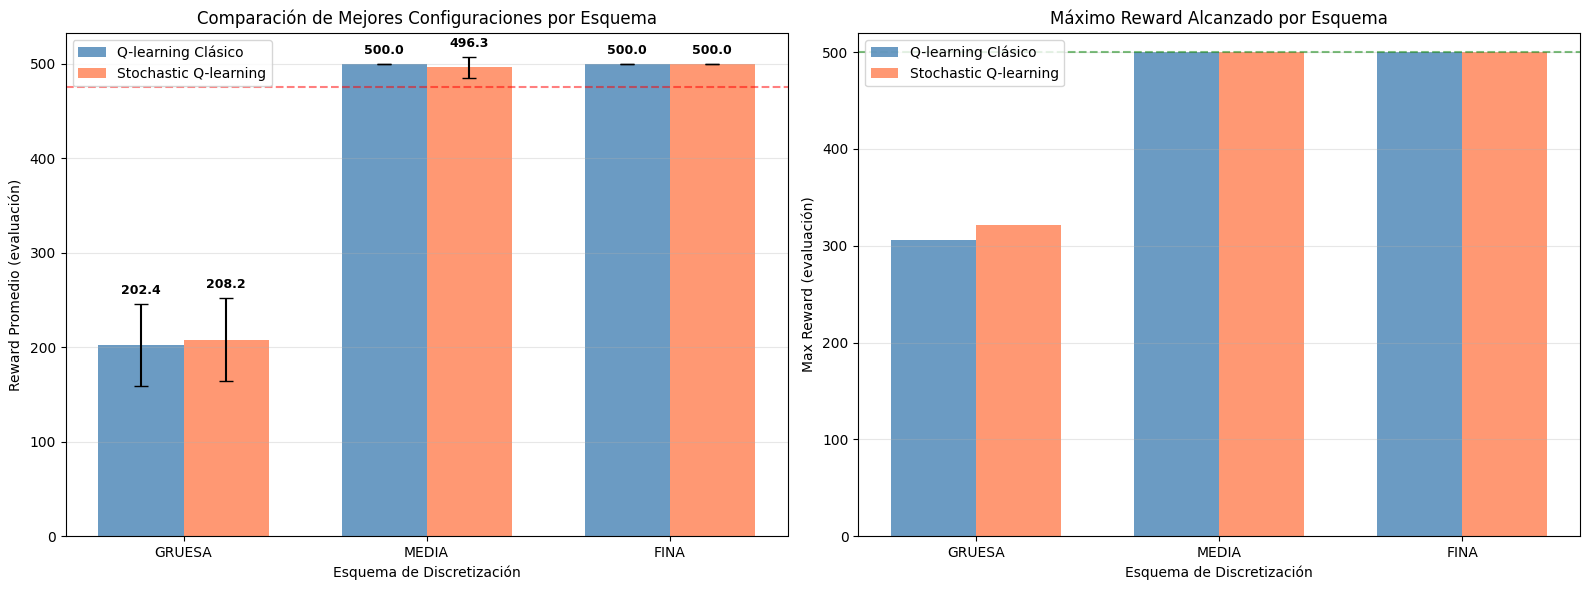


COMPARACIÓN DETALLADA: MEJORES CONFIGURACIONES

GRUESA:
  CLÁSICO: 202.43 ± 43.58 (alpha=0.1, eps_decay=0.992)
  ESTOCÁSTICO: 208.23 ± 44.04 (alpha=0.05, eps_decay=0.995, memory=True, size=1)
  ✅ MEJORA: +5.80 puntos (+2.87%)

MEDIA:
  CLÁSICO: 499.96 ± 0.40 (alpha=0.2, eps_decay=0.992)
  ESTOCÁSTICO: 496.28 ± 11.20 (alpha=0.05, eps_decay=0.999, memory=True, size=2)
  ❌ DEGRADACIÓN: -3.68 puntos (-0.74%)

FINA:
  CLÁSICO: 500.00 ± 0.00 (alpha=0.2, eps_decay=0.99)
  ESTOCÁSTICO: 500.00 ± 0.00 (alpha=0.25, eps_decay=0.999, memory=True, size=1)
  ➖ EMPATE: Sin diferencia significativa


In [11]:
import matplotlib.pyplot as plt

# Extraer mejores resultados por esquema para cada algoritmo
best_classic = {}
best_stoch = {}

for scheme in ['GRUESA', 'MEDIA', 'FINA']:
    # Mejor clásico
    classic_best = df_grid[df_grid['scheme'] == scheme].nlargest(1, 'mean_reward').iloc[0]
    best_classic[scheme] = {
        'mean': classic_best['mean_reward'],
        'std': classic_best['std_reward'],
        'max': classic_best['max_reward'],
        'alpha': classic_best['alpha'],
        'eps_decay': classic_best['epsilon_decay']
    }
    
    # Mejor estocástico
    stoch_best = df_grid_stoch[df_grid_stoch['scheme'] == scheme].nlargest(1, 'mean_reward').iloc[0]
    best_stoch[scheme] = {
        'mean': stoch_best['mean_reward'],
        'std': stoch_best['std_reward'],
        'max': stoch_best['max_reward'],
        'alpha': stoch_best['alpha'],
        'eps_decay': stoch_best['epsilon_decay'],
        'use_memory': stoch_best['use_memory'],
        'memory_size': stoch_best['memory_size']
    }

# Crear gráficos de comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

schemes = ['GRUESA', 'MEDIA', 'FINA']
x_pos = np.arange(len(schemes))
width = 0.35

# Gráfico 1: Reward promedio con barras de error
means_classic = [best_classic[s]['mean'] for s in schemes]
stds_classic = [best_classic[s]['std'] for s in schemes]
means_stoch = [best_stoch[s]['mean'] for s in schemes]
stds_stoch = [best_stoch[s]['std'] for s in schemes]

axes[0].bar(x_pos - width/2, means_classic, width, yerr=stds_classic, 
            label='Q-learning Clásico', alpha=0.8, capsize=5, color='steelblue')
axes[0].bar(x_pos + width/2, means_stoch, width, yerr=stds_stoch, 
            label='Stochastic Q-learning', alpha=0.8, capsize=5, color='coral')
axes[0].set_xlabel('Esquema de Discretización')
axes[0].set_ylabel('Reward Promedio (evaluación)')
axes[0].set_title('Comparación de Mejores Configuraciones por Esquema')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(schemes)
axes[0].legend()
axes[0].axhline(y=475, color='red', linestyle='--', alpha=0.5, label='Objetivo 475')
axes[0].grid(True, alpha=0.3, axis='y')

# Añadir valores sobre las barras
for i, scheme in enumerate(schemes):
    axes[0].text(i - width/2, means_classic[i] + stds_classic[i] + 10, 
                f'{means_classic[i]:.1f}', ha='center', fontsize=9, fontweight='bold')
    axes[0].text(i + width/2, means_stoch[i] + stds_stoch[i] + 10, 
                f'{means_stoch[i]:.1f}', ha='center', fontsize=9, fontweight='bold')

# Gráfico 2: Max reward alcanzado
maxs_classic = [best_classic[s]['max'] for s in schemes]
maxs_stoch = [best_stoch[s]['max'] for s in schemes]

axes[1].bar(x_pos - width/2, maxs_classic, width, 
            label='Q-learning Clásico', alpha=0.8, color='steelblue')
axes[1].bar(x_pos + width/2, maxs_stoch, width, 
            label='Stochastic Q-learning', alpha=0.8, color='coral')
axes[1].set_xlabel('Esquema de Discretización')
axes[1].set_ylabel('Max Reward (evaluación)')
axes[1].set_title('Máximo Reward Alcanzado por Esquema')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(schemes)
axes[1].legend()
axes[1].axhline(y=500, color='green', linestyle='--', alpha=0.5, label='Objetivo 500')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 520])

plt.tight_layout()
plt.show()

print("\n" + "="*120)
print("COMPARACIÓN DETALLADA: MEJORES CONFIGURACIONES")
print("="*120)
for scheme in schemes:
    print(f"\n{scheme}:")
    print(f"  CLÁSICO: {best_classic[scheme]['mean']:.2f} ± {best_classic[scheme]['std']:.2f} "
          f"(alpha={best_classic[scheme]['alpha']}, eps_decay={best_classic[scheme]['eps_decay']})")
    print(f"  ESTOCÁSTICO: {best_stoch[scheme]['mean']:.2f} ± {best_stoch[scheme]['std']:.2f} "
          f"(alpha={best_stoch[scheme]['alpha']}, eps_decay={best_stoch[scheme]['eps_decay']}, "
          f"memory={best_stoch[scheme]['use_memory']}, size={best_stoch[scheme]['memory_size']})")
    
    improvement = best_stoch[scheme]['mean'] - best_classic[scheme]['mean']
    improvement_pct = (improvement / best_classic[scheme]['mean']) * 100 if best_classic[scheme]['mean'] > 0 else 0
    
    if improvement > 0:
        print(f"  MEJORA: +{improvement:.2f} puntos ({improvement_pct:+.2f}%)")
    elif improvement < 0:
        print(f"  DEGRADACION: {improvement:.2f} puntos ({improvement_pct:.2f}%)")
    else:
        print(f"  EMPATE: Sin diferencia significativa")

print("="*120)

### Análisis del Impacto de la Memoria

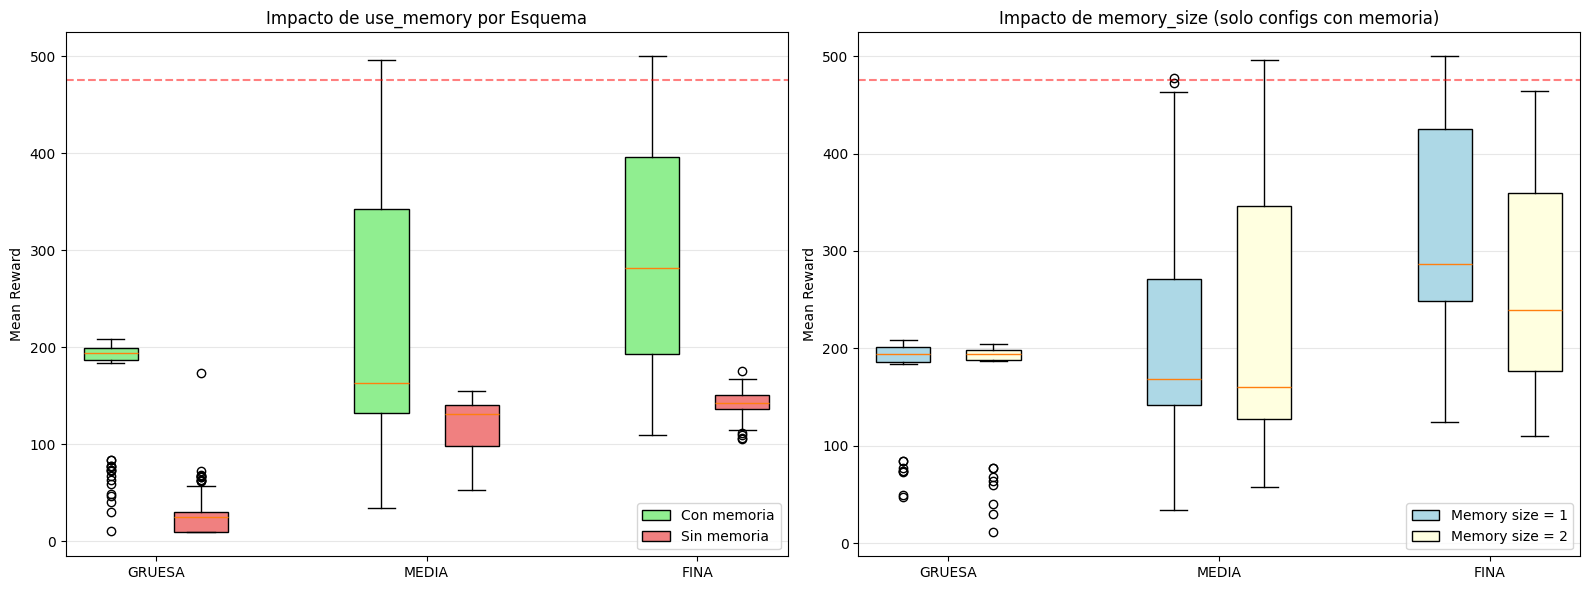


ANÁLISIS ESTADÍSTICO: IMPACTO DE MEMORIA

GRUESA:
  Con memoria (todas): 165.92 ± 58.09
  Sin memoria: 28.39 ± 25.96
  Diferencia: +137.53 (+484.53%)

  Desglose por memory_size (solo con memoria):
    Memory size = 1: 168.27 ± 54.75
    Memory size = 2: 163.57 ± 61.96
    Diferencia: -4.70

MEDIA:
  Con memoria (todas): 221.47 ± 136.56
  Sin memoria: 118.34 ± 25.76
  Diferencia: +103.13 (+87.15%)

  Desglose por memory_size (solo con memoria):
    Memory size = 1: 220.03 ± 136.04
    Memory size = 2: 222.92 ± 139.04
    Diferencia: +2.89

FINA:
  Con memoria (todas): 293.98 ± 113.20
  Sin memoria: 141.88 ± 14.21
  Diferencia: +152.11 (+107.21%)

  Desglose por memory_size (solo con memoria):
    Memory size = 1: 316.80 ± 109.87
    Memory size = 2: 271.16 ± 113.40
    Diferencia: -45.64


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Análisis del impacto de use_memory y memory_size
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Boxplot comparando use_memory
schemes = ['GRUESA', 'MEDIA', 'FINA']
data_with_mem = [df_grid_stoch[(df_grid_stoch['scheme'] == s) & (df_grid_stoch['use_memory'] == True)]['mean_reward'].values for s in schemes]
data_without_mem = [df_grid_stoch[(df_grid_stoch['scheme'] == s) & (df_grid_stoch['use_memory'] == False)]['mean_reward'].values for s in schemes]

positions_with = [1, 4, 7]
positions_without = [2, 5, 8]

bp1 = axes[0].boxplot(data_with_mem, positions=positions_with, widths=0.6, 
                       patch_artist=True, label='Con memoria')
bp2 = axes[0].boxplot(data_without_mem, positions=positions_without, widths=0.6, 
                       patch_artist=True, label='Sin memoria')

for patch in bp1['boxes']:
    patch.set_facecolor('lightgreen')
for patch in bp2['boxes']:
    patch.set_facecolor('lightcoral')

axes[0].set_xticks([1.5, 4.5, 7.5])
axes[0].set_xticklabels(schemes)
axes[0].set_ylabel('Mean Reward')
axes[0].set_title('Impacto de use_memory por Esquema')
axes[0].legend([bp1["boxes"][0], bp2["boxes"][0]], ['Con memoria', 'Sin memoria'])
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=475, color='red', linestyle='--', alpha=0.5)

# Gráfico 2: Impacto de memory_size (solo para configs con memoria)
data_mem_size_1 = [df_grid_stoch[(df_grid_stoch['scheme'] == s) & 
                                  (df_grid_stoch['use_memory'] == True) & 
                                  (df_grid_stoch['memory_size'] == 1)]['mean_reward'].values for s in schemes]
data_mem_size_2 = [df_grid_stoch[(df_grid_stoch['scheme'] == s) & 
                                  (df_grid_stoch['use_memory'] == True) & 
                                  (df_grid_stoch['memory_size'] == 2)]['mean_reward'].values for s in schemes]

bp3 = axes[1].boxplot(data_mem_size_1, positions=positions_with, widths=0.6, 
                       patch_artist=True, label='Memory size = 1')
bp4 = axes[1].boxplot(data_mem_size_2, positions=positions_without, widths=0.6, 
                       patch_artist=True, label='Memory size = 2')

for patch in bp3['boxes']:
    patch.set_facecolor('lightblue')
for patch in bp4['boxes']:
    patch.set_facecolor('lightyellow')

axes[1].set_xticks([1.5, 4.5, 7.5])
axes[1].set_xticklabels(schemes)
axes[1].set_ylabel('Mean Reward')
axes[1].set_title('Impacto de memory_size (solo configs con memoria)')
axes[1].legend([bp3["boxes"][0], bp4["boxes"][0]], ['Memory size = 1', 'Memory size = 2'])
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=475, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Tabla estadística del impacto
print("\n" + "="*120)
print("ANÁLISIS ESTADÍSTICO: IMPACTO DE MEMORIA")
print("="*120)

for scheme in schemes:
    scheme_data = df_grid_stoch[df_grid_stoch['scheme'] == scheme]
    
    with_mem = scheme_data[scheme_data['use_memory'] == True]
    without_mem = scheme_data[scheme_data['use_memory'] == False]
    
    mem_size_1 = scheme_data[(scheme_data['use_memory'] == True) & (scheme_data['memory_size'] == 1)]
    mem_size_2 = scheme_data[(scheme_data['use_memory'] == True) & (scheme_data['memory_size'] == 2)]
    
    print(f"\n{scheme}:")
    print(f"  Con memoria (todas): {with_mem['mean_reward'].mean():.2f} ± {with_mem['mean_reward'].std():.2f}")
    print(f"  Sin memoria: {without_mem['mean_reward'].mean():.2f} ± {without_mem['mean_reward'].std():.2f}")
    
    if len(with_mem) > 0 and len(without_mem) > 0:
        diff = with_mem['mean_reward'].mean() - without_mem['mean_reward'].mean()
        diff_pct = (diff / without_mem['mean_reward'].mean()) * 100
        print(f"  Diferencia: {diff:+.2f} ({diff_pct:+.2f}%)")
    
    print(f"\n  Desglose por memory_size (solo con memoria):")
    print(f"    Memory size = 1: {mem_size_1['mean_reward'].mean():.2f} ± {mem_size_1['mean_reward'].std():.2f}")
    print(f"    Memory size = 2: {mem_size_2['mean_reward'].mean():.2f} ± {mem_size_2['mean_reward'].std():.2f}")
    
    if len(mem_size_1) > 0 and len(mem_size_2) > 0:
        diff_size = mem_size_2['mean_reward'].mean() - mem_size_1['mean_reward'].mean()
        print(f"    Diferencia: {diff_size:+.2f}")

print("="*120)

### Heatmaps para Stochastic Q-learning

Visualización del reward promedio en función de alpha y epsilon_decay para cada esquema. Se muestra el mejor reward obtenido para cada combinación (considerando todas las configuraciones de memoria).

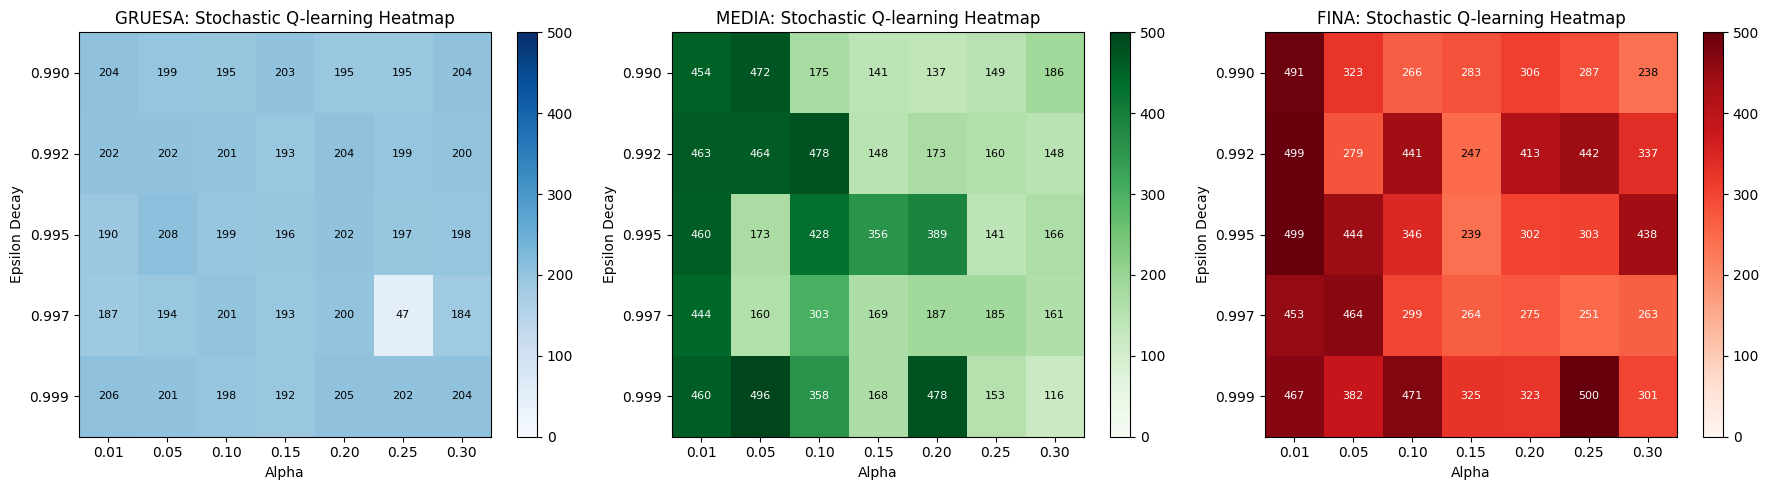


Interpretación de Heatmaps Stochastic Q-learning:
- Colores más oscuros indican mejores rewards
- Cada celda muestra el MEJOR reward para esa combinación (alpha, eps_decay)
- Se consideran todas las configuraciones de memoria (use_memory y memory_size)
- Comparar con los heatmaps clásicos para identificar diferencias en las zonas óptimas


In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

schemes = ['GRUESA', 'MEDIA', 'FINA']
colors = {'GRUESA': 'Blues', 'MEDIA': 'Greens', 'FINA': 'Reds'}

for idx, scheme_name in enumerate(schemes):
    scheme_data = df_grid_stoch[df_grid_stoch['scheme'] == scheme_name]
    
    if len(scheme_data) > 0:
        alphas = sorted(scheme_data['alpha'].unique())
        eps_decays = sorted(scheme_data['epsilon_decay'].unique())
        
        heatmap_data = np.zeros((len(eps_decays), len(alphas)))
        
        # Para cada combinación de alpha y epsilon_decay, tomar el mejor reward
        # (considerando todas las combinaciones de use_memory y memory_size)
        for i, eps_decay in enumerate(eps_decays):
            for j, alpha in enumerate(alphas):
                subset = scheme_data[
                    (scheme_data['alpha'] == alpha) & 
                    (scheme_data['epsilon_decay'] == eps_decay)
                ]
                if len(subset) > 0:
                    heatmap_data[i, j] = subset['mean_reward'].max()
        
        im = axes[idx].imshow(heatmap_data, cmap=colors[scheme_name], aspect='auto', 
                              vmin=0, vmax=500, interpolation='nearest')
        axes[idx].set_xticks(range(len(alphas)))
        axes[idx].set_yticks(range(len(eps_decays)))
        axes[idx].set_xticklabels([f'{a:.2f}' for a in alphas])
        axes[idx].set_yticklabels([f'{ed:.3f}' for ed in eps_decays])
        axes[idx].set_xlabel('Alpha')
        axes[idx].set_ylabel('Epsilon Decay')
        axes[idx].set_title(f'{scheme_name}: Stochastic Q-learning Heatmap')
        
        # Añadir valores en cada celda
        for i in range(len(eps_decays)):
            for j in range(len(alphas)):
                value = heatmap_data[i, j]
                if value > 0:
                    text_color = 'white' if value > 250 else 'black'
                    axes[idx].text(j, i, f'{value:.0f}', 
                                  ha='center', va='center', color=text_color, fontsize=8)
        
        plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

print("\nInterpretación de Heatmaps Stochastic Q-learning:")
print("- Colores más oscuros indican mejores rewards")
print("- Cada celda muestra el MEJOR reward para esa combinación (alpha, eps_decay)")
print("- Se consideran todas las configuraciones de memoria (use_memory y memory_size)")
print("- Comparar con los heatmaps clásicos para identificar diferencias en las zonas óptimas")